# Train Dataset Exploration

In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import random

In [ ]:
random.seed(42)
ids = [i for i in range(1, 590)]
random.shuffle(ids)
split_index = int(0.8 * len(ids))

train_ids = ids[:split_index]
val_ids = ids[split_index:]

dataset_split = {id: "train" for id in train_ids}
dataset_split.update({id: "val" for id in val_ids})

print(f"Train IDs: {len(train_ids)}")
print(f"Validation IDs: {len(val_ids)}")
print(f"Total IDs: {len(dataset_split)}")

Train IDs: 471
Validation IDs: 118
Total IDs: 589


In [ ]:
grouped_split = {"train": [], "val": []}
for index, split in dataset_split.items():
    grouped_split[split].append(index)
print(grouped_split)

{'train': [491, 570, 149, 154, 188, 201, 231, 84, 585, 412, 444, 470, 60, 464, 378, 384, 486, 303, 417, 537, 241, 532, 316, 286, 304, 173, 179, 266, 355, 308, 427, 571, 407, 13, 93, 459, 101, 185, 22, 119, 315, 544, 514, 484, 89, 428, 405, 507, 478, 219, 450, 320, 141, 202, 401, 248, 255, 538, 262, 317, 381, 132, 372, 76, 165, 339, 156, 131, 357, 180, 177, 148, 463, 252, 190, 334, 16, 97, 446, 120, 377, 477, 246, 437, 67, 183, 423, 456, 400, 351, 496, 396, 290, 589, 337, 555, 139, 159, 117, 326, 212, 189, 5, 107, 75, 23, 222, 15, 376, 436, 169, 108, 87, 408, 397, 422, 551, 462, 361, 9, 187, 270, 43, 133, 475, 298, 363, 413, 500, 242, 346, 342, 52, 473, 268, 218, 287, 487, 431, 69, 295, 146, 503, 292, 566, 106, 46, 178, 61, 501, 259, 327, 91, 576, 64, 199, 434, 309, 318, 425, 438, 545, 111, 38, 540, 150, 228, 414, 443, 314, 20, 29, 216, 144, 546, 572, 114, 263, 365, 565, 541, 305, 418, 12, 480, 548, 194, 24, 14, 398, 126, 236, 208, 163, 526, 53, 88, 184, 54, 155, 313, 70, 40, 213, 191, 

In [ ]:
len(os.listdir("drive/MyDrive/npz_files"))

589

In [ ]:
# 13 минут

data_path = "drive/MyDrive/npz_files"
slice_info = []
bounding_boxes = []

# Intermediate variables for the global bounding box
min_x, min_y, max_x, max_y = np.inf, np.inf, -np.inf, -np.inf

probability_map = np.zeros((512, 512))
total_slices_with_pancreas = 0

# Walk through all studies
for file_name in sorted(os.listdir(data_path)):
    if file_name.endswith(".npz"):
        cur_number = int(file_name.split("_")[1][:4])

        # Process only the training set
        if cur_number not in grouped_split["train"]:
            continue

        if cur_number % 50 == 0 or cur_number == 1:
            print(f"Processing study № {cur_number} ...")

        data = np.load(os.path.join(data_path, file_name))
        mask = data["mask"]

        start_slice, end_slice = None, None
        local_min_x, local_min_y, local_max_x, local_max_y = np.inf, np.inf, -np.inf, -np.inf

        # Walk through all slices of the study
        for i in range(mask.shape[2]):
            slice_mask = mask[:, :, i]
            if np.any(slice_mask > 0):  # If there is a pancreas on the slice
                # Update start and end slices ids
                if start_slice is None:
                    start_slice = i
                end_slice = i

                # Probability Map Update
                probability_map += (slice_mask > 0).astype(int)
                total_slices_with_pancreas += 1

                # Updating local bounding box
                non_zero_coords = np.argwhere(slice_mask > 0)
                x_min, y_min = non_zero_coords.min(axis=0)
                x_max, y_max = non_zero_coords.max(axis=0)
                local_min_x = min(local_min_x, x_min)
                local_min_y = min(local_min_y, y_min)
                local_max_x = max(local_max_x, x_max)
                local_max_y = max(local_max_y, y_max)

        if start_slice is not None and end_slice is not None:
            slice_info.append({
                "file_name": file_name,
                "start_slice": start_slice,
                "end_slice": end_slice,
                "total_slices": mask.shape[2],
                "bounding_box": [local_min_x, local_min_y, local_max_x, local_max_y]
            })

            bounding_boxes.append([local_min_x, local_min_y, local_max_x, local_max_y])

            # Update global bounding box
            min_x = min(min_x, local_min_x)
            min_y = min(min_y, local_min_y)
            max_x = max(max_x, local_max_x)
            max_y = max(max_y, local_max_y)

# Probability map normalization
probability_map /= total_slices_with_pancreas

df = pd.DataFrame(slice_info)
df.to_csv("slice_info.csv", index=False)

Processing study № 1 ...
Processing study № 50 ...
Processing study № 150 ...
Processing study № 200 ...
Processing study № 250 ...
Processing study № 350 ...
Processing study № 400 ...
Processing study № 450 ...
Processing study № 500 ...
Processing study № 550 ...


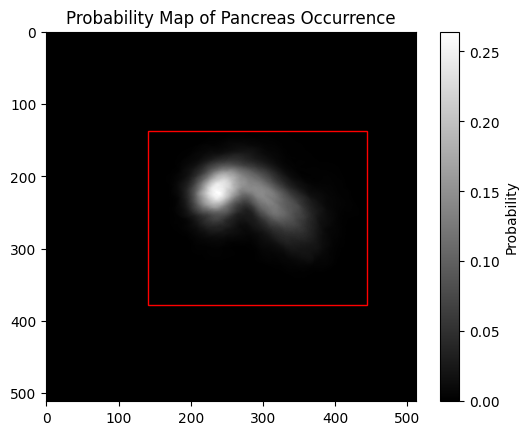

In [ ]:
plt.imshow(probability_map, cmap='gray')
plt.colorbar(label='Probability')
plt.title('Probability Map of Pancreas Occurrence')

rect = plt.Rectangle((min_y, min_x), max_y - min_y, max_x - min_x, edgecolor='red', facecolor='none')
plt.gca().add_patch(rect)

plt.show()

In [ ]:
min_x, min_y, max_x, max_y

(137, 140, 378, 444)

In [ ]:
max_x - min_x, max_y - min_y

(241, 304)

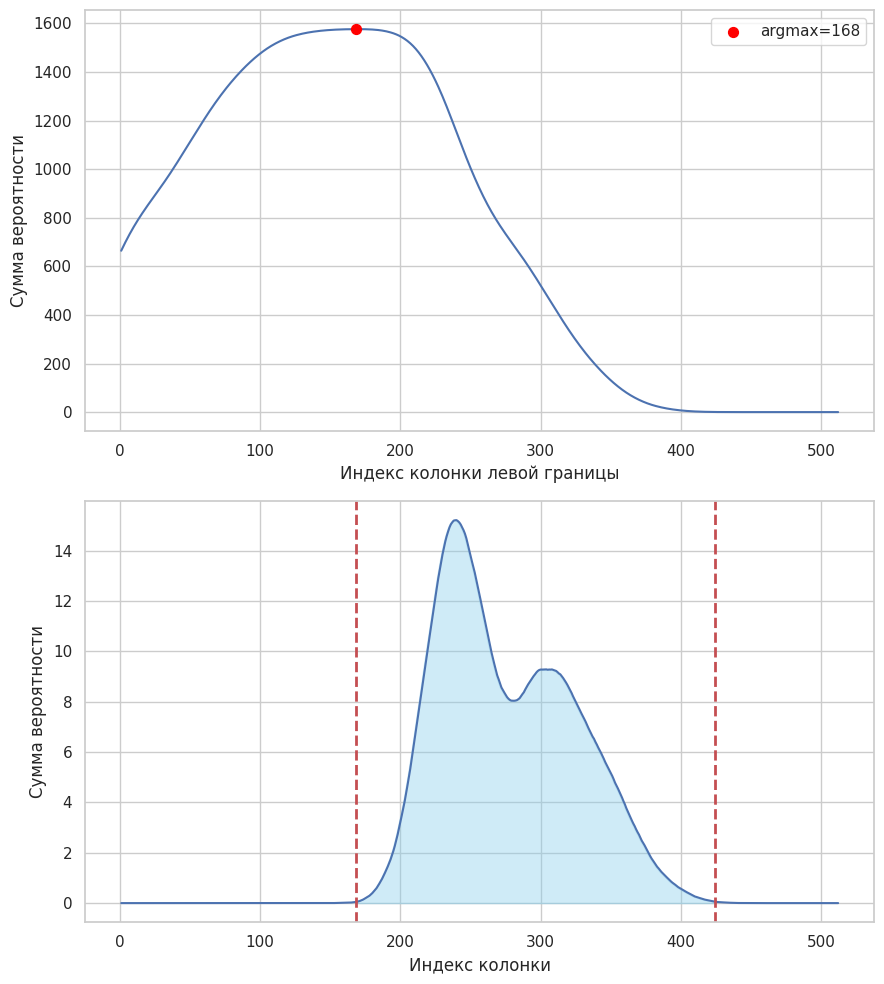

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

prob_map = probability_map
column_sums = np.sum(prob_map, axis=0)

# Calculation of the total probability value depending on the initial index of the left border of a frame of width 256
original_width = 304
new_width = 256
center = prob_map.shape[1] // 2
start_col = center - original_width // 2
prob_map_limited = prob_map[:, start_col:start_col + original_width]
column_sums_limited = np.sum(prob_map_limited, axis=0)

sum_probabilities = np.zeros(512)
for i in range(512):
    sum_probabilities[i] = np.sum(column_sums[i:i + new_width])

sns.set(style="whitegrid")
fig, ax = plt.subplots(2, 1, figsize=(9, 10))
sns.lineplot(x=range(1, 513), y=sum_probabilities, ax=ax[0])
ax[0].set_xlabel('Индекс колонки левой границы', fontsize=12)
ax[0].set_ylabel('Сумма вероятности', fontsize=12)
argmax_index = 168
ax[0].scatter(argmax_index, sum_probabilities[argmax_index-1], color='red', s=50, zorder=5, label='argmax=168')
ax[0].legend()

sns.lineplot(x=range(1, 513), y=column_sums)
ax[1].set_xlabel('Индекс колонки', fontsize=12)
ax[1].set_ylabel('Сумма вероятности', fontsize=12)
ax[1].axvline(x=168, color='r', linestyle='--', linewidth=2)
ax[1].axvline(x=168 + 256, color='r', linestyle='--', linewidth=2)
start_shade = 168
end_shade = 168 + 256
ax[1].fill_between(range(start_shade, end_shade), column_sums[start_shade:end_shade], color='skyblue', alpha=0.4)

plt.tight_layout()
plt.show()

In [ ]:
sum_probabilities.argmax()

168

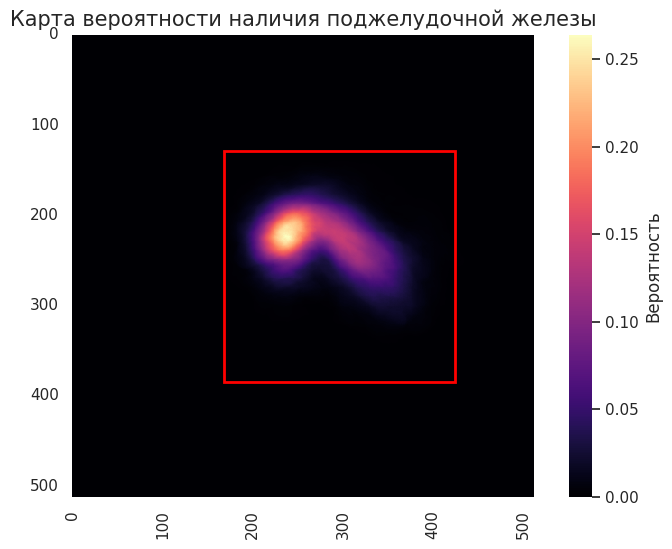

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(9, 6))
ax = sns.heatmap(probability_map, cmap="magma", cbar_kws={"label": "Вероятность"}, square=True)
xticks = np.arange(0, probability_map.shape[1], 100)
yticks = np.arange(0, probability_map.shape[0], 100)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xticklabels(xticks)
ax.set_yticklabels(yticks)
rect = plt.Rectangle((168, min_x-8), 256, 256, linewidth=2, edgecolor="red", facecolor="none")
ax.add_patch(rect)
plt.title("Карта вероятности наличия поджелудочной железы", fontsize=15)
plt.show()

# Dataset preparation

In [ ]:
!pip -q install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 50.3 MB/s eta 0:00:00


In [ ]:
import glob
import json
import numpy as np
import os
import pandas as pd
from PIL import Image
import random
from scipy import ndimage
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch
from torchmetrics import JaccardIndex, F1Score
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [ ]:
os.makedirs("training_data/data3d/train/cts", exist_ok=True)
os.makedirs("training_data/data3d/train/masks", exist_ok=True)
os.makedirs("training_data/data3d/val/cts", exist_ok=True)
os.makedirs("training_data/data3d/val/masks", exist_ok=True)

In [ ]:
def crop_and_pad_image(image: np.ndarray,
                       slope_start: float,
                       intercept_start: float,
                       slope_end: float,
                       intercept_end: float) -> np.ndarray:

    target_depth = 256
    N = image.shape[2]

    # Horizontal and vertical cropping
    cropped_image = image[129:129+target_depth, 168:168+target_depth, :]

    # Computation of start and end depth indices
    start_pred = slope_start * N + intercept_start
    start_pred = int(np.round(start_pred))
    end_pred = slope_end * N + intercept_end
    end_pred = int(np.round(end_pred))
    # print("start_pred, end_pred", start_pred, end_pred)   ########################

    # Check and adjust values so that the difference is equal to 256
    pancreas_depth_pred = end_pred - start_pred
    # print("pancreas_depth_pred", pancreas_depth_pred)   ########################

    if N >= target_depth:

        if pancreas_depth_pred < target_depth:
            diff = target_depth - pancreas_depth_pred
            half_diff = diff // 2
            start_pred = max(0, start_pred - half_diff)
            end_pred = min(N, end_pred + (diff - half_diff))

            # Re-verification after correction
            pancreas_depth_pred = end_pred - start_pred

            # If still not equal to 256, increase the size to the bounds of the original image
            if pancreas_depth_pred < target_depth:
                if start_pred == 0:
                    end_pred = target_depth
                if end_pred == N:
                    start_pred = N - target_depth

            # print("start_pred, end_pred", start_pred, end_pred)   ########################

        elif pancreas_depth_pred > target_depth:
            diff = pancreas_depth_pred - target_depth
            start_pred = diff // 2
            end_pred = diff - start_pred

        depth_cropped_image = cropped_image[:, :, start_pred:end_pred]

    else:
        # If there are not enough layers, add zero padding
        depth_cropped_image = np.zeros((256, 256, target_depth), dtype=image.dtype)
        padding_needed = target_depth - N
        ratio = 1.84    # The pancreas is located in about the first third of the images (see data exploration)
        front_padding_idx = int(padding_needed / (1 + ratio)) + 1
        back_padding_idx = target_depth - (padding_needed - front_padding_idx)
        depth_cropped_image[:, :, front_padding_idx:back_padding_idx] = cropped_image[:, :, :]

    return depth_cropped_image

In [ ]:
def create3d(patient_path: str,
             split_group: str,
             regression_line_parameters: tuple[float, float, float, float]
             ) -> tuple[str, str]:

    data = np.load(patient_path)
    image = data["image"]
    mask = data["mask"]

    slope_start, intercept_start, slope_end, intercept_end = regression_line_parameters

    assert image.shape == mask.shape, f"{patient_path} Размерность изображения и маски должна быть одинаковая"

    patient_id = os.path.split(patient_path)[1].split(".")[0]

    # print("image.shape", image.shape)   #########################################
    # Stack 3D slices and convert them into torch tensors
    image_cropped = crop_and_pad_image(image, slope_start, intercept_start, slope_end, intercept_end)
    assert image_cropped.shape == (256, 256, 256), f"{patient_path} Размерность обрезанного изображения должна быть (256, 256, 256), а не {image_cropped.shape}"

    mask_cropped = crop_and_pad_image(mask, slope_start, intercept_start, slope_end, intercept_end)
    assert mask_cropped.shape == (256, 256, 256), f"{patient_path} Размерность обрезанного изображения должна быть (256, 256, 256), а не {mask_cropped.shape}"

    image_cropped = np.transpose(image_cropped, axes=(2, 0, 1))  # -> (D x H x W)
    mask_cropped = np.transpose(mask_cropped, axes=(2, 0, 1))  # -> (D x H x W)

    image_cropped = torch.as_tensor(image_cropped)
    image_cropped = image_cropped.type(torch.FloatTensor)
    mask_cropped = torch.as_tensor(mask_cropped)

    desired_height = 128
    current_height = image_cropped.shape[1]
    height_factor = desired_height / current_height

    desired_width = 128
    current_width = image_cropped.shape[2]
    width_factor = desired_width / current_width

    desired_depth = 128
    current_depth = image_cropped.shape[0]
    depth_factor = desired_depth / current_depth

    # Create and save resized 3D ct tensor
    # order=1 - bi-linear interpolation
    ct_3d = ndimage.zoom(image_cropped, zoom=(depth_factor, height_factor, width_factor), order=1)
    ct_path = os.path.join("training_data", "data3d", split_group, "cts", patient_id + "_ct.pt")
    torch.save(ct_3d, ct_path)  # -> (D x H x W)

    mask_cropped = mask_cropped.numpy()
    mask_path = os.path.join("training_data", "data3d", split_group, "masks", patient_id + "_mask.pt")
    torch.save(mask_cropped, mask_path)  # -> (D x H x W)

    return ct_path, mask_path

In [ ]:
random.seed(42)
ids = [i for i in range(1, 590)]
random.shuffle(ids)
split_index = int(0.8 * len(ids))

train_ids = ids[:split_index]
val_ids = ids[split_index:]

dataset_split = {id: "train" for id in train_ids}
dataset_split.update({id: "val" for id in val_ids})

print(f"Train IDs: {len(train_ids)}")
print(f"Validation IDs: {len(val_ids)}")
print(f"Total IDs: {len(dataset_split)}")

Train IDs: 471
Validation IDs: 118
Total IDs: 589


In [ ]:
print(dataset_split)

{491: 'train', 570: 'train', 149: 'train', 154: 'train', 188: 'train', 201: 'train', 231: 'train', 84: 'train', 585: 'train', 412: 'train', 444: 'train', 470: 'train', 60: 'train', 464: 'train', 378: 'train', 384: 'train', 486: 'train', 303: 'train', 417: 'train', 537: 'train', 241: 'train', 532: 'train', 316: 'train', 286: 'train', 304: 'train', 173: 'train', 179: 'train', 266: 'train', 355: 'train', 308: 'train', 427: 'train', 571: 'train', 407: 'train', 13: 'train', 93: 'train', 459: 'train', 101: 'train', 185: 'train', 22: 'train', 119: 'train', 315: 'train', 544: 'train', 514: 'train', 484: 'train', 89: 'train', 428: 'train', 405: 'train', 507: 'train', 478: 'train', 219: 'train', 450: 'train', 320: 'train', 141: 'train', 202: 'train', 401: 'train', 248: 'train', 255: 'train', 538: 'train', 262: 'train', 317: 'train', 381: 'train', 132: 'train', 372: 'train', 76: 'train', 165: 'train', 339: 'train', 156: 'train', 131: 'train', 357: 'train', 180: 'train', 177: 'train', 148: 'train'

In [ ]:
# !rm -r training_data

In [ ]:
# 16 минут

patients_paths = sorted(glob.glob("drive/MyDrive/npz_files/*"))
patients_count = len(patients_paths)

data = pd.read_csv("slice_info_training_part.csv")
slope_start, intercept_start = np.polyfit(data["total_slices"], data["start_slice"], 1)
slope_end, intercept_end = np.polyfit(data["total_slices"], data["end_slice"], 1)
regression_line_parameters = (slope_start, intercept_start, slope_end, intercept_end)

for i, pth in enumerate(patients_paths):
    if (i + 1) % 50 == 0 or i == 0:
        print("Processing patient {}/{} ...".format(i + 1, patients_count))
    paths3d = create3d(pth, dataset_split[i + 1], regression_line_parameters)

Processing patient 1/588 ...
Processing patient 50/588 ...
Processing patient 100/588 ...
Processing patient 150/588 ...
Processing patient 200/588 ...
Processing patient 250/588 ...
Processing patient 300/588 ...
Processing patient 350/588 ...
Processing patient 400/588 ...
Processing patient 450/588 ...
Processing patient 500/588 ...
Processing patient 550/588 ...


(128, 128, 128) (256, 256, 256)


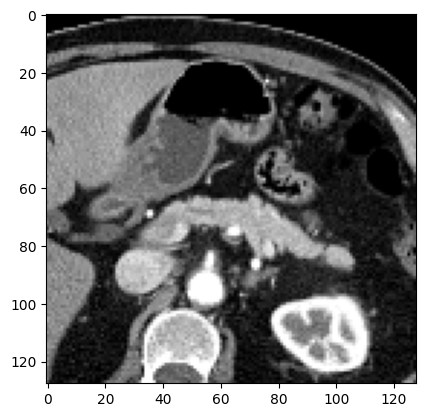

In [ ]:
import matplotlib.pyplot as plt

img = torch.load("training_data/data3d/train/cts/pancreas_0570_ct.pt")
mask = torch.load("training_data/data3d/train/masks/pancreas_0570_mask.pt")
print(img.shape, mask.shape)
plt.imshow(img[60,:,:], cmap="gray")

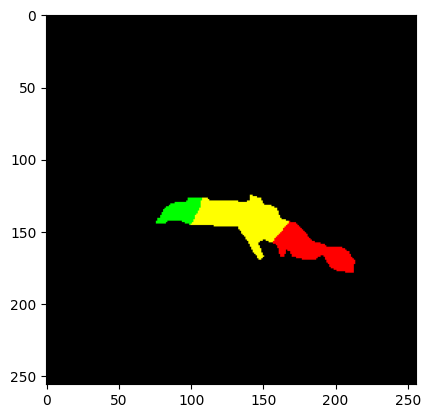

In [ ]:
rgb_images = np.zeros((mask.shape[0], mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
rgb_images[mask == 0] = (0,0,0)
rgb_images[mask == 1] = (0,0,255)
rgb_images[mask == 2] = (0,255,0)
rgb_images[mask == 3] = (255,255,0)
rgb_images[mask == 4] = (255,0,0)
plt.imshow(rgb_images[120,:,:])

In [ ]:
import os
import torch

def check_files(directory, expected_shape_cts, expected_shape_masks):
    """
    Checking files in a given directory for compliance with expected sizes.

    :param directory: Directory with training data
    :param expected_shape_cts: Expected size for cts files
    :param expected_shape_masks: Expected size for masks files
    """
    subdirs = ["train", "val"]
    data_types = ["cts", "masks"]

    for subdir in subdirs:
        for data_type in data_types:
            path = os.path.join(directory, subdir, data_type)
            expected_shape = expected_shape_cts if data_type == "cts" else expected_shape_masks

            for root, _, files in os.walk(path):
                for file in files:
                    if file.endswith(".pt"):
                        file_path = os.path.join(root, file)
                        try:
                            data = torch.load(file_path)
                            data_shape = data.shape

                            if data_shape != expected_shape:
                                print(f"Файл {file_path} имеет размер {data_shape}, но ожидается {expected_shape}")
                        except Exception as e:
                            print(f"Ошибка при загрузке файла {file_path}: {e}")

directory = "training_data/data3d"
expected_shape_cts = (128, 128, 128)
expected_shape_masks = (256, 256, 256)

# Running a check
check_files(directory, expected_shape_cts, expected_shape_masks)

# Training WITHOUT Class Weights

In [ ]:
class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=5, features=16, dropout_rate=0.3):
        super().__init__()

        # Encoder
        self.encoder1 = UNet3D.conv_block(in_channels, features)
        self.encoder2 = UNet3D.conv_block(features, features * 2)
        self.encoder3 = UNet3D.conv_block(features * 2, features * 4)
        self.encoder4 = UNet3D.conv_block(features * 4, features * 8)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = UNet3D.conv_block(features * 4, features * 8)

        # Decoder
        self.upconv4 = nn.ConvTranspose3d(features * 16, features * 16, kernel_size=2, stride=2)
        self.decoder4 = UNet3D.conv_block(features * 24, features * 8)
        self.upconv3 = nn.ConvTranspose3d(features * 8, features * 8, kernel_size=2, stride=2)
        self.decoder3 = UNet3D.conv_block(features * 12, features * 4)
        self.upconv2 = nn.ConvTranspose3d(features * 4, features * 4, kernel_size=2, stride=2)
        self.decoder2 = UNet3D.conv_block(features * 6, features * 2)
        self.upconv1 = nn.ConvTranspose3d(features * 2, features * 2, kernel_size=2, stride=2)
        self.decoder1 = UNet3D.conv_block(features * 3, features)

        # Output layer
        self.last_conv = nn.Conv3d(in_channels=features, out_channels=out_channels, kernel_size=1)
        self.last_upconv1 = nn.ConvTranspose3d(out_channels, out_channels, kernel_size=2, stride=2)
        # self.last_upconv2 = nn.ConvTranspose3d(out_channels, out_channels, kernel_size=2, stride=2)   #################

        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):

        # Encoding path
        enc1_copy = self.encoder1(x)
        enc1 = self.dropout(self.pool(enc1_copy))
        enc2_copy = self.encoder2(enc1)
        enc2 = self.dropout(self.pool(enc2_copy))
        enc3_copy = self.encoder3(enc2)
        enc3 = self.dropout(self.pool(enc3_copy))
        # enc4_copy = self.encoder4(enc3)
        # enc4 = self.dropout(self.pool(enc4_copy))

        # Bottleneck
        # bn = self.bottleneck(enc4)
        bn = self.bottleneck(enc3)
        # bn = self.bottleneck(enc2)

        # Decoding path
        # dec4 = self.dropout(self.upconv4(bn))
        # dec4 = self.decoder4(torch.cat((dec4, enc4_copy), dim=1))
        dec3 = self.dropout(self.upconv3(bn))
        dec3 = self.decoder3(torch.cat((dec3, enc3_copy), dim=1))
        dec2 = self.dropout(self.upconv2(dec3))
        dec2 = self.decoder2(torch.cat((dec2, enc2_copy), dim=1))
        dec1 = self.dropout(self.upconv1(dec2))
        dec1 = self.decoder1(torch.cat((dec1, enc1_copy), dim=1))
        output = self.last_conv(dec1)
        output = self.last_upconv1(output)
        # output = self.last_upconv2(output)    ###########################

        return output

    @staticmethod
    def conv_block(in_features, out_features):
        return nn.Sequential(
            nn.Conv3d(
                in_channels=in_features,
                out_channels=out_features,
                kernel_size=3,
                padding=1
                ),
            nn.BatchNorm3d(num_features=out_features),
            nn.ReLU(),
            nn.Conv3d(
                in_channels=out_features,
                out_channels=out_features,
                kernel_size=3,
                padding=1
                ),
            nn.BatchNorm3d(num_features=out_features),
            nn.ReLU()
        )

In [ ]:
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet3D().to(device)
summary(model, (1, 128, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1    [-1, 16, 128, 128, 128]             448
       BatchNorm3d-2    [-1, 16, 128, 128, 128]              32
              ReLU-3    [-1, 16, 128, 128, 128]               0
            Conv3d-4    [-1, 16, 128, 128, 128]           6,928
       BatchNorm3d-5    [-1, 16, 128, 128, 128]              32
              ReLU-6    [-1, 16, 128, 128, 128]               0
         MaxPool3d-7       [-1, 16, 64, 64, 64]               0
           Dropout-8       [-1, 16, 64, 64, 64]               0
            Conv3d-9       [-1, 32, 64, 64, 64]          13,856
      BatchNorm3d-10       [-1, 32, 64, 64, 64]              64
             ReLU-11       [-1, 32, 64, 64, 64]               0
           Conv3d-12       [-1, 32, 64, 64, 64]          27,680
      BatchNorm3d-13       [-1, 32, 64, 64, 64]              64
             ReLU-14       [-1, 32, 64,

In [ ]:
class PartSegmentationDataset(Dataset):
    def __init__(self, root_dir, transform=False):
        self.root_dir = root_dir
        self.cts = sorted(os.listdir(os.path.join(self.root_dir, "cts")))
        self.masks = sorted(os.listdir(os.path.join(self.root_dir, "masks")))
        self.transform = transform
        assert len(self.cts) == len(self.masks), "Количество изображений и масок должно совпадать"

    def __len__(self):
        return len(self.cts)

    def __getitem__(self, idx):
        # load tensors
        image_path = os.path.join(self.root_dir, "cts", self.cts[idx])
        mask_path = os.path.join(self.root_dir, "masks", self.masks[idx])
        # add channel dimension
        image = torch.load(image_path)
        image = torch.from_numpy(image).unsqueeze(0)     # -> shape = (C, D, H, W)
        mask = torch.load(mask_path)
        mask = torch.from_numpy(mask).unsqueeze(0)   # -> shape = (C, D, H, W)

        # scale ct images
        image = image / 255.0

        # restore data type after transformation
        image = image.type(torch.FloatTensor)
        mask = mask.type(torch.IntTensor)

        return image, mask

In [ ]:
def save_dicts(losses, metrics, file_path):
    with open(file_path, "w") as f:
        json.dump({"losses": losses, "metrics": metrics}, f)

def train(model, train_dl, val_dl, n_epochs, optimizer, criterion, device, scheduler):
    iouscore = JaccardIndex(
        task="multiclass",
        num_classes=5,
        average=None
    ).to(device)  # inputs are logits/probabilities (torch.argmax is built in JaccardIndex)
    f1score = F1Score(
        task="multiclass",
        num_classes=5,
        average=None
    ).to(device)  # inputs are logits/probabilities (torch.argmax is built in F1Score)
    losses = {"train": [], "val": []}
    metrics = {"IoU": {"train": [], "val": []},
               "F1score": {"train": [], "val": []}}
    show_every = 10
    for epoch in tqdm(range(1, n_epochs+1), total=n_epochs+1):
        print(f"=== Epoch #{epoch} ===")

        ###################
        # Train the model #
        ###################
        model.train()
        train_loss = 0.0
        per_batch_train_iou = []
        per_batch_train_f1 = []
        print("=== Training ===")
        for batch_idx, (data, target) in enumerate(train_dl):
            data = data.to(device)
            target = target.squeeze(1).to(device)   # (B x C x D x H x W) -> (B x D x H x W)
            target = target.to(torch.long)
            if batch_idx % show_every == 0:
                print(f"{batch_idx + 1} / {len(train_dl)} ...")
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            # Step the scheduler after each batch
            scheduler.step()
            # Save average loss
            train_loss += (loss / len(train_dl)).item()
            # Save metrics
            per_batch_train_iou.append(iouscore(output, target).tolist())
            per_batch_train_f1.append(f1score(output, target).tolist())
            # Print first epoch statistics
            if epoch == 1 and (batch_idx % show_every == 0 or batch_idx == 0):
                print(
                    "Batch IDX {}: Training Loss: {:.4f} \tTrain IoU: {} \tTrain F1: {}".format(
                        batch_idx,
                        train_loss,
                        per_batch_train_iou[-1],
                        per_batch_train_f1[-1]
                    ))
        losses["train"].append(train_loss)
        metrics["IoU"]["train"].append(np.mean(per_batch_train_iou, axis=0).tolist())
        metrics["F1score"]["train"].append(np.mean(per_batch_train_f1, axis=0).tolist())

        ######################
        # Validate the model #
        ######################
        print("=== Validation ===")
        valid_loss = 0.0
        per_batch_val_iou = []
        per_batch_val_f1 = []
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_dl):
                if batch_idx % show_every == 0:
                    print(f"{batch_idx + 1} / {len(val_dl)} ...")
                data = data.to(device)
                target = target.squeeze(1).to(device)   # (B x C x D x H x W) -> (B x D x H x W)
                target = target.to(torch.long)
                output = model(data)
                # Save average loss
                loss = criterion(output, target)
                valid_loss += (loss / len(val_dl)).item()
                # Save metrics
                per_batch_val_iou.append(iouscore(output, target).tolist())
                per_batch_val_f1.append(f1score(output, target).tolist())
            losses["val"].append(valid_loss)
            val_iou = np.mean(per_batch_val_iou, axis=0).tolist()
            val_f1 = np.mean(per_batch_val_f1, axis=0).tolist()
            metrics["IoU"]["val"].append(val_iou)
            metrics["F1score"]["val"].append(val_f1)

        # Save model
        if epoch % 10 == 0:
            torch.save(model.state_dict(), f"CroppedUNet{epoch}epochsCP.pt")
        # Save losses and metrics
        save_dicts(losses, metrics, "history.json")

        # Print training/validation statistics
        print(
            "Epoch: {} \tTraining Loss: {:.4f} \tValidation Loss: {:.4f} \tValidation F1 Score: {} \tValidation IoU: {}".format(
                epoch,
                train_loss,
                valid_loss,
                val_f1,
                val_iou
            ))

    # Save the final model
    torch.save(model.state_dict(), "CroppedUNetcp.pt")

    return model

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
!rm -r training_data/data3d/train/cts/.ipynb_checkpoints
!rm -r training_data/data3d/train/masks/.ipynb_checkpoints

In [ ]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_seed(42)

In [ ]:
batch_size = 4
root_dir = os.path.join("training_data", "data3d")
dataset_train = PartSegmentationDataset(os.path.join(root_dir, "train"), transform=False) #######
dataset_val = PartSegmentationDataset(os.path.join(root_dir, "val"), transform=False)
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model and the training parameters
model = UNet3D().to(device)
n_epochs = 200
# try reduction="sum" if gradients are too small
criterion = torch.nn.CrossEntropyLoss(reduction="mean")
learning_rate = 1e-1  # 1e-3  # 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
iterations_per_epoch = len(train_dataloader)
# The learning rate will increase over 5 epochs, then there will be a similar decreasing cycle
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-4, max_lr=1e-1,
                                              step_size_up=iterations_per_epoch * 5,
                                              mode="triangular2")

# Training
model = train(
    model, train_dataloader, val_dataloader,
    n_epochs, optimizer, criterion, device, scheduler
)

  0%|          | 0/201 [00:00<?, ?it/s]

=== Epoch #1 ===
=== Training ===
1 / 118 ...
Batch IDX 0: Training Loss: 0.0143 	Train IoU: [0.04086518660187721, 0.002043294720351696, 0.00021279725478962064, 0.0011913328198716044, 0.0011293666902929544] 	Train F1: [0.07852156460285187, 0.004078255966305733, 0.00042550399666652083, 0.0023798304609954357, 0.002256185282021761]
11 / 118 ...
Batch IDX 10: Training Loss: 0.1556 	Train IoU: [0.19188886880874634, 0.0015290897572413087, 0.00016657904780004174, 0.000614078831858933, 0.0007954089669510722] 	Train F1: [0.3219912052154541, 0.0030535103287547827, 0.0003331025945954025, 0.0012274038745090365, 0.001589553547091782]
21 / 118 ...
Batch IDX 20: Training Loss: 0.2889 	Train IoU: [0.5106061100959778, 0.0029973771888762712, 0.00011895961506525055, 0.0005395713378675282, 0.0015428232727572322] 	Train F1: [0.6760280728340149, 0.005976839456707239, 0.00023789092665538192, 0.0010785607155412436, 0.0030808933079242706]
31 / 118 ...
Batch IDX 30: Training Loss: 0.3963 	Train IoU: [0.99574589

  0%|          | 1/201 [02:58<9:55:15, 178.58s/it]

Epoch: 1 	Training Loss: 0.4650 	Validation Loss: 0.0215 	Validation F1 Score: [0.9980926811695099, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961935619513194, 0.0, 0.0, 0.0, 0.0]
=== Epoch #2 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  1%|          | 2/201 [05:57<9:53:33, 178.96s/it]

Epoch: 2 	Training Loss: 0.0212 	Validation Loss: 0.0251 	Validation F1 Score: [0.9980926811695099, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961935619513194, 0.0, 0.0, 0.0, 0.0]
=== Epoch #3 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  1%|▏         | 3/201 [08:55<9:49:21, 178.59s/it]

Epoch: 3 	Training Loss: 0.0200 	Validation Loss: 0.0194 	Validation F1 Score: [0.9980926811695099, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961935619513194, 0.0, 0.0, 0.0, 0.0]
=== Epoch #4 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  2%|▏         | 4/201 [11:53<9:45:09, 178.22s/it]

Epoch: 4 	Training Loss: 0.0184 	Validation Loss: 0.0181 	Validation F1 Score: [0.9980926811695099, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961935619513194, 0.0, 0.0, 0.0, 0.0]
=== Epoch #5 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  2%|▏         | 5/201 [14:51<9:41:45, 178.09s/it]

Epoch: 5 	Training Loss: 0.0182 	Validation Loss: 0.0199 	Validation F1 Score: [0.9980926811695099, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961935619513194, 0.0, 0.0, 0.0, 0.0]
=== Epoch #6 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  3%|▎         | 6/201 [17:49<9:38:36, 178.03s/it]

Epoch: 6 	Training Loss: 0.0171 	Validation Loss: 0.0184 	Validation F1 Score: [0.9980926811695099, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961935619513194, 0.0, 0.0, 0.0, 0.0]
=== Epoch #7 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  3%|▎         | 7/201 [20:47<9:35:20, 177.94s/it]

Epoch: 7 	Training Loss: 0.0155 	Validation Loss: 0.0190 	Validation F1 Score: [0.9980926811695099, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961935619513194, 0.0, 0.0, 0.0, 0.0]
=== Epoch #8 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  4%|▍         | 8/201 [23:44<9:32:14, 177.90s/it]

Epoch: 8 	Training Loss: 0.0147 	Validation Loss: 0.0167 	Validation F1 Score: [0.9980926811695099, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961935619513194, 0.0, 0.0, 0.0, 0.0]
=== Epoch #9 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  4%|▍         | 9/201 [26:42<9:29:12, 177.88s/it]

Epoch: 9 	Training Loss: 0.0137 	Validation Loss: 0.0152 	Validation F1 Score: [0.9980926811695099, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961935619513194, 0.0, 0.0, 0.0, 0.0]
=== Epoch #10 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  5%|▍         | 10/201 [29:40<9:26:25, 177.93s/it]

Epoch: 10 	Training Loss: 0.0130 	Validation Loss: 0.0149 	Validation F1 Score: [0.9980926811695099, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961935619513194, 0.0, 0.0, 0.0, 0.0]
=== Epoch #11 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  5%|▌         | 11/201 [32:38<9:23:22, 177.91s/it]

Epoch: 11 	Training Loss: 0.0127 	Validation Loss: 0.0151 	Validation F1 Score: [0.9980926811695099, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961935619513194, 0.0, 0.0, 0.0, 0.0]
=== Epoch #12 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  6%|▌         | 12/201 [35:36<9:20:14, 177.86s/it]

Epoch: 12 	Training Loss: 0.0127 	Validation Loss: 0.0164 	Validation F1 Score: [0.9980926811695099, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961935619513194, 0.0, 0.0, 0.0, 0.0]
=== Epoch #13 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  6%|▋         | 13/201 [38:34<9:17:25, 177.90s/it]

Epoch: 13 	Training Loss: 0.0128 	Validation Loss: 0.0152 	Validation F1 Score: [0.9980926811695099, 0.0, 0.0, 0.0, 0.0] 	Validation IoU: [0.9961935619513194, 0.0, 0.0, 0.0, 0.0]
=== Epoch #14 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  7%|▋         | 14/201 [41:32<9:14:24, 177.89s/it]

Epoch: 14 	Training Loss: 0.0129 	Validation Loss: 0.0162 	Validation F1 Score: [0.9981164455413818, 0.05728316682616423, 0.0, 0.0, 0.0] 	Validation IoU: [0.9962409019470215, 0.030061935789368967, 0.0, 0.0, 0.0]
=== Epoch #15 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  7%|▋         | 15/201 [44:30<9:11:29, 177.90s/it]

Epoch: 15 	Training Loss: 0.0127 	Validation Loss: 0.0164 	Validation F1 Score: [0.9981878141562144, 0.2723510283899183, 0.0, 0.0, 0.0] 	Validation IoU: [0.9963831822077434, 0.16368245149884994, 0.0, 0.0, 0.0]
=== Epoch #16 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  8%|▊         | 16/201 [47:28<9:08:25, 177.87s/it]

Epoch: 16 	Training Loss: 0.0129 	Validation Loss: 0.0153 	Validation F1 Score: [0.9983335097630819, 0.39199514836072924, 0.0, 0.0, 0.0] 	Validation IoU: [0.9966734250386556, 0.24967492247621217, 0.0, 0.0, 0.0]
=== Epoch #17 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  8%|▊         | 17/201 [50:25<9:05:30, 177.88s/it]

Epoch: 17 	Training Loss: 0.0121 	Validation Loss: 0.0151 	Validation F1 Score: [0.9984468897183736, 0.4819815109173457, 0.0, 0.0, 0.0] 	Validation IoU: [0.9968993703524271, 0.32124960124492646, 0.0, 0.0, 0.0]
=== Epoch #18 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  9%|▉         | 18/201 [53:23<9:02:37, 177.91s/it]

Epoch: 18 	Training Loss: 0.0116 	Validation Loss: 0.0152 	Validation F1 Score: [0.9984330415725708, 0.43718069791793823, 0.0, 0.0, 0.0] 	Validation IoU: [0.9968717376391093, 0.28511206023395064, 0.0, 0.0, 0.0]
=== Epoch #19 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  9%|▉         | 19/201 [56:21<8:59:36, 177.89s/it]

Epoch: 19 	Training Loss: 0.0109 	Validation Loss: 0.0144 	Validation F1 Score: [0.9985222140947978, 0.5022739777962367, 0.0, 0.0, 0.0] 	Validation IoU: [0.9970495641231537, 0.3398726145426432, 0.0, 0.0, 0.0]
=== Epoch #20 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 10%|▉         | 20/201 [59:19<8:56:36, 177.88s/it]

Epoch: 20 	Training Loss: 0.0107 	Validation Loss: 0.0142 	Validation F1 Score: [0.998522671063741, 0.5005166083574295, 0.0, 0.0, 0.0] 	Validation IoU: [0.9970505038897196, 0.3390548566977183, 0.0, 0.0, 0.0]
=== Epoch #21 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 10%|█         | 21/201 [1:02:17<8:53:25, 177.81s/it]

Epoch: 21 	Training Loss: 0.0105 	Validation Loss: 0.0145 	Validation F1 Score: [0.9985076586405436, 0.49051809360583626, 0.0, 0.0, 0.0] 	Validation IoU: [0.9970205426216125, 0.3302116071184476, 0.0, 0.0, 0.0]
=== Epoch #22 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 11%|█         | 22/201 [1:05:15<8:50:28, 177.81s/it]

Epoch: 22 	Training Loss: 0.0106 	Validation Loss: 0.0143 	Validation F1 Score: [0.9985368251800537, 0.5005254964033763, 0.0, 0.0, 0.0] 	Validation IoU: [0.9970787286758422, 0.3389058450857798, 0.0, 0.0, 0.0]
=== Epoch #23 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 11%|█▏        | 23/201 [1:08:12<8:47:28, 177.80s/it]

Epoch: 23 	Training Loss: 0.0105 	Validation Loss: 0.0142 	Validation F1 Score: [0.9985867043336233, 0.4675363476077716, 0.0, 0.0, 0.0] 	Validation IoU: [0.9971782326698303, 0.30847251961628597, 0.0, 0.0, 0.0]
=== Epoch #24 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 12%|█▏        | 24/201 [1:11:10<8:44:35, 177.83s/it]

Epoch: 24 	Training Loss: 0.0106 	Validation Loss: 0.0148 	Validation F1 Score: [0.9983783384164174, 0.44078068832556405, 0.0, 0.0, 0.0] 	Validation IoU: [0.9967628618081411, 0.2896567337214947, 0.0, 0.0, 0.0]
=== Epoch #25 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 12%|█▏        | 25/201 [1:14:08<8:41:32, 177.80s/it]

Epoch: 25 	Training Loss: 0.0107 	Validation Loss: 0.0143 	Validation F1 Score: [0.998512210448583, 0.4547049606839816, 0.0, 0.0, 0.0] 	Validation IoU: [0.997029701868693, 0.29641038353244464, 0.0, 0.0, 0.0]
=== Epoch #26 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 13%|█▎        | 26/201 [1:17:06<8:38:30, 177.77s/it]

Epoch: 26 	Training Loss: 0.0104 	Validation Loss: 0.0153 	Validation F1 Score: [0.9984775364398957, 0.5515148371458054, 0.0, 0.0, 0.0] 	Validation IoU: [0.9969604889551799, 0.3859136993686358, 0.0, 0.0, 0.0]
=== Epoch #27 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 13%|█▎        | 27/201 [1:20:03<8:35:26, 177.74s/it]

Epoch: 27 	Training Loss: 0.0100 	Validation Loss: 0.0136 	Validation F1 Score: [0.9984212001164754, 0.6068940073251724, 0.00013376088633473653, 0.0, 0.0] 	Validation IoU: [0.9968481202920277, 0.44131751110156375, 6.68999999713075e-05, 0.0, 0.0]
=== Epoch #28 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 14%|█▍        | 28/201 [1:23:01<8:32:14, 177.66s/it]

Epoch: 28 	Training Loss: 0.0095 	Validation Loss: 0.0148 	Validation F1 Score: [0.9984395702679952, 0.5477298006415368, 0.0, 0.09432043453950124, 0.0002764570166618796] 	Validation IoU: [0.9968847811222077, 0.38453071266412736, 0.0, 0.050364923496575405, 0.00013828863032661805]
=== Epoch #29 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 14%|█▍        | 29/201 [1:25:58<8:29:17, 177.66s/it]

Epoch: 29 	Training Loss: 0.0091 	Validation Loss: 0.0143 	Validation F1 Score: [0.9984733879566192, 0.5820348600546519, 0.0, 0.14040664140484296, 0.0012908105753012932] 	Validation IoU: [0.9969522098700205, 0.4180675779779752, 0.0, 0.07710502812260529, 0.000646268795268649]
=== Epoch #30 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 15%|█▍        | 30/201 [1:28:56<8:26:21, 177.67s/it]

Epoch: 30 	Training Loss: 0.0086 	Validation Loss: 0.0136 	Validation F1 Score: [0.9985771755377452, 0.6256861905256907, 0.0, 0.27976165019596616, 0.0018406695761465622] 	Validation IoU: [0.9971591432889303, 0.46135030686855316, 0.0, 0.16687608941768606, 0.0009217615188087318]
=== Epoch #31 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 15%|█▌        | 31/201 [1:31:54<8:23:28, 177.70s/it]

Epoch: 31 	Training Loss: 0.0084 	Validation Loss: 0.0142 	Validation F1 Score: [0.998565689722697, 0.6237556546926498, 0.0, 0.26293528514603776, 0.0029021246523673956] 	Validation IoU: [0.9971362253030142, 0.4593105047941208, 0.0, 0.15533162135009965, 0.0014544348103906182]
=== Epoch #32 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 16%|█▌        | 32/201 [1:34:52<8:20:31, 177.70s/it]

Epoch: 32 	Training Loss: 0.0084 	Validation Loss: 0.0134 	Validation F1 Score: [0.9986050426959991, 0.6369863659143448, 0.0, 0.32033397580186523, 0.0012225146162866925] 	Validation IoU: [0.9972146729628245, 0.4728858028848966, 0.0, 0.19672524922837814, 0.0006118841619657663]
=== Epoch #33 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 16%|█▋        | 33/201 [1:37:49<8:17:40, 177.74s/it]

Epoch: 33 	Training Loss: 0.0083 	Validation Loss: 0.0138 	Validation F1 Score: [0.9986126065254212, 0.6340923458337784, 0.0, 0.33726705685257913, 0.006272094516316429] 	Validation IoU: [0.9972297628720601, 0.47086046636104584, 0.0, 0.20801375011603038, 0.0031529388414734665]
=== Epoch #34 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 17%|█▋        | 34/201 [1:40:47<8:14:38, 177.71s/it]

Epoch: 34 	Training Loss: 0.0080 	Validation Loss: 0.0148 	Validation F1 Score: [0.9985024114449819, 0.6254890561103821, 0.0, 0.2904874762520194, 0.0] 	Validation IoU: [0.9970100204149882, 0.45919485290845236, 0.0, 0.17761604618281127, 0.0]
=== Epoch #35 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 17%|█▋        | 35/201 [1:43:45<8:11:44, 177.74s/it]

Epoch: 35 	Training Loss: 0.0078 	Validation Loss: 0.0138 	Validation F1 Score: [0.9986451963583628, 0.5842076073090235, 0.0, 0.41452527840932213, 0.001982480713316666] 	Validation IoU: [0.9972948590914409, 0.4192604452371597, 0.0, 0.27074793316423895, 0.000993385880671364]
=== Epoch #36 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 18%|█▊        | 36/201 [1:46:43<8:08:42, 177.71s/it]

Epoch: 36 	Training Loss: 0.0074 	Validation Loss: 0.0127 	Validation F1 Score: [0.9987045705318451, 0.6407725671927135, 0.0, 0.48512647350629173, 0.07892756648361683] 	Validation IoU: [0.9974133094151815, 0.47595996111631395, 0.0, 0.32759952495495476, 0.04214374447086205]
=== Epoch #37 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 18%|█▊        | 37/201 [1:49:40<8:05:47, 177.73s/it]

Epoch: 37 	Training Loss: 0.0071 	Validation Loss: 0.0138 	Validation F1 Score: [0.9987384816010793, 0.6072903295358022, 0.0, 0.4374330900609493, 0.20669365357607603] 	Validation IoU: [0.9974809169769288, 0.4434959585467974, 0.0, 0.28808202762156726, 0.11896665239085753]
=== Epoch #38 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 19%|█▉        | 38/201 [1:52:38<8:02:45, 177.70s/it]

Epoch: 38 	Training Loss: 0.0069 	Validation Loss: 0.0139 	Validation F1 Score: [0.9987400392691295, 0.6459813674290975, 0.0, 0.48602127879858015, 0.2702110147724549] 	Validation IoU: [0.9974840184052786, 0.4812294691801071, 0.0, 0.330888365333279, 0.16240819357335567]
=== Epoch #39 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 19%|█▉        | 39/201 [1:55:36<7:59:50, 177.72s/it]

Epoch: 39 	Training Loss: 0.0067 	Validation Loss: 0.0129 	Validation F1 Score: [0.9987687170505524, 0.6555998305479686, 0.0, 0.4831311730047067, 0.28808632188787064] 	Validation IoU: [0.9975411891937256, 0.4929651081562042, 0.0, 0.3284986216574907, 0.1748291455519696]
=== Epoch #40 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 20%|█▉        | 40/201 [1:58:33<7:56:36, 177.62s/it]

Epoch: 40 	Training Loss: 0.0064 	Validation Loss: 0.0132 	Validation F1 Score: [0.9987854699293772, 0.6545883387327194, 0.0, 0.5082320044438045, 0.32850088390211263] 	Validation IoU: [0.9975746313730876, 0.4911910722653071, 0.0, 0.35087332874536514, 0.20526326205581427]
=== Epoch #41 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 20%|██        | 41/201 [2:01:31<7:53:34, 177.59s/it]

Epoch: 41 	Training Loss: 0.0063 	Validation Loss: 0.0132 	Validation F1 Score: [0.9987863659858703, 0.6493974566459656, 0.0, 0.4876695251713196, 0.34405503844221436] 	Validation IoU: [0.9975764195124308, 0.48611189275979994, 0.0, 0.3331825801481803, 0.21765599151452383]
=== Epoch #42 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 21%|██        | 42/201 [2:04:28<7:50:33, 177.57s/it]

Epoch: 42 	Training Loss: 0.0063 	Validation Loss: 0.0124 	Validation F1 Score: [0.9987764259179434, 0.6525061239798864, 0.0, 0.5005152329802514, 0.3662990521639585] 	Validation IoU: [0.9975566287835439, 0.4890043745438258, 0.0, 0.34405144055684406, 0.23450499462584654]
=== Epoch #43 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 21%|██▏       | 43/201 [2:07:26<7:47:42, 177.61s/it]

Epoch: 43 	Training Loss: 0.0064 	Validation Loss: 0.0132 	Validation F1 Score: [0.9987546145915985, 0.6458068877458573, 0.0, 0.5126965100566546, 0.3636137317866087] 	Validation IoU: [0.9975130637486775, 0.48044357895851136, 0.0, 0.35514175730446973, 0.23316483478993177]
=== Epoch #44 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 22%|██▏       | 44/201 [2:10:23<7:44:41, 177.59s/it]

Epoch: 44 	Training Loss: 0.0064 	Validation Loss: 0.0130 	Validation F1 Score: [0.9987814048926036, 0.6506325622399648, 0.0, 0.4775307048112154, 0.39564600102603437] 	Validation IoU: [0.997566533088684, 0.4868117521206538, 0.0, 0.325507902726531, 0.2604061876734098]
=== Epoch #45 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 22%|██▏       | 45/201 [2:13:21<7:41:41, 177.58s/it]

Epoch: 45 	Training Loss: 0.0063 	Validation Loss: 0.0128 	Validation F1 Score: [0.9987932403882345, 0.6286246120929718, 5.760388012276962e-06, 0.5392283871769905, 0.4562830701470375] 	Validation IoU: [0.9975902120272319, 0.46457102050383886, 2.8803238819818945e-06, 0.3794684166709582, 0.3121258554359277]
=== Epoch #46 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 23%|██▎       | 46/201 [2:16:19<7:38:42, 177.56s/it]

Epoch: 46 	Training Loss: 0.0062 	Validation Loss: 0.0127 	Validation F1 Score: [0.9987570484479268, 0.653616514801979, 0.0028251728828763588, 0.5687726775805155, 0.4573921997100115] 	Validation IoU: [0.9975179553031921, 0.48912213345368705, 0.0014153511054852666, 0.4091245837509632, 0.3166047565639019]
=== Epoch #47 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 23%|██▎       | 47/201 [2:19:16<7:35:42, 177.55s/it]

Epoch: 47 	Training Loss: 0.0059 	Validation Loss: 0.0127 	Validation F1 Score: [0.9987795352935791, 0.6542405098676681, 0.021023905432472626, 0.5775588884949684, 0.4556912623345852] 	Validation IoU: [0.9975628018379211, 0.4902378479639689, 0.010674059150430064, 0.4174131150046984, 0.31589839085936544]
=== Epoch #48 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 24%|██▍       | 48/201 [2:22:13<7:32:39, 177.51s/it]

Epoch: 48 	Training Loss: 0.0058 	Validation Loss: 0.0124 	Validation F1 Score: [0.9988073348999024, 0.6571106970310211, 0.04044903653363387, 0.5804842586318651, 0.46953796185553076] 	Validation IoU: [0.9976182500521342, 0.4947564343611399, 0.02075546745521327, 0.4197307695945104, 0.3284417138124506]
=== Epoch #49 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 24%|██▍       | 49/201 [2:25:11<7:29:37, 177.48s/it]

Epoch: 49 	Training Loss: 0.0055 	Validation Loss: 0.0127 	Validation F1 Score: [0.9988123595714569, 0.6621757388114929, 0.05629303976893425, 0.5767203946908315, 0.4856942263742288] 	Validation IoU: [0.9976282775402069, 0.500177763402462, 0.029263315621453026, 0.41766931638121607, 0.34338824519266686]
=== Epoch #50 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 25%|██▍       | 50/201 [2:28:09<7:26:55, 177.59s/it]

Epoch: 50 	Training Loss: 0.0054 	Validation Loss: 0.0125 	Validation F1 Score: [0.9988156219323476, 0.6649799625078837, 0.0626095821770529, 0.5852734352151553, 0.48811217236022153] 	Validation IoU: [0.9976347744464874, 0.5033447821935018, 0.032659433937321104, 0.4259643343587716, 0.3457545924310883]
=== Epoch #51 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 25%|██▌       | 51/201 [2:31:06<7:23:58, 177.59s/it]

Epoch: 51 	Training Loss: 0.0054 	Validation Loss: 0.0129 	Validation F1 Score: [0.9988154252370198, 0.6570398718118667, 0.058002556394785645, 0.5754540865619977, 0.49950031712651255] 	Validation IoU: [0.9976343890031178, 0.4948534895976385, 0.03017417249890665, 0.41623406087358794, 0.3558423347771168]
=== Epoch #52 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 26%|██▌       | 52/201 [2:34:03<7:20:44, 177.48s/it]

Epoch: 52 	Training Loss: 0.0053 	Validation Loss: 0.0126 	Validation F1 Score: [0.9988038857777913, 0.655592542886734, 0.08405061083224913, 0.5543722713987033, 0.47071094177663325] 	Validation IoU: [0.997611387570699, 0.4932799071073532, 0.04471627492845679, 0.3967285049458345, 0.32949820862462126]
=== Epoch #53 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 26%|██▋       | 53/201 [2:37:01<7:17:39, 177.43s/it]

Epoch: 53 	Training Loss: 0.0053 	Validation Loss: 0.0126 	Validation F1 Score: [0.9987966636816661, 0.6597214589516321, 0.08889668577661117, 0.5643241350849469, 0.5154445350170136] 	Validation IoU: [0.9975969731807709, 0.49735302676757176, 0.04744446336602171, 0.4061510540544987, 0.3694153698782126]
=== Epoch #54 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 27%|██▋       | 54/201 [2:39:58<7:14:40, 177.42s/it]

Epoch: 54 	Training Loss: 0.0054 	Validation Loss: 0.0125 	Validation F1 Score: [0.9988187869389852, 0.6563813408215841, 0.12096838746219873, 0.5775973856449127, 0.46016259007155896] 	Validation IoU: [0.9976410726706187, 0.4943351954221725, 0.06587631249179443, 0.41979284783204396, 0.32207144163548945]
=== Epoch #55 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 27%|██▋       | 55/201 [2:42:56<7:11:42, 177.42s/it]

Epoch: 55 	Training Loss: 0.0053 	Validation Loss: 0.0124 	Validation F1 Score: [0.9988146344820659, 0.6545540908972423, 0.14106604636957248, 0.5843690633773804, 0.49036291167140006] 	Validation IoU: [0.9976328392823537, 0.4925029695034027, 0.0783079649011294, 0.42632844522595403, 0.3484905255958438]
=== Epoch #56 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 28%|██▊       | 56/201 [2:45:53<7:08:42, 177.40s/it]

Epoch: 56 	Training Loss: 0.0053 	Validation Loss: 0.0124 	Validation F1 Score: [0.9988251050313314, 0.6514363646507263, 0.22179814018309116, 0.5825594728191693, 0.48453849417467915] 	Validation IoU: [0.9976537187894186, 0.48923519204060234, 0.12828232310712337, 0.42420970698197685, 0.3428790450717012]
=== Epoch #57 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 28%|██▊       | 57/201 [2:48:51<7:05:54, 177.46s/it]

Epoch: 57 	Training Loss: 0.0051 	Validation Loss: 0.0126 	Validation F1 Score: [0.9988350848356883, 0.6620683421691259, 0.2166607559969028, 0.5899680018424988, 0.5048730372140805] 	Validation IoU: [0.9976736168066661, 0.5006287162502606, 0.12460740202416977, 0.4325319540997346, 0.3628569499279062]
=== Epoch #58 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 29%|██▉       | 58/201 [2:51:48<7:02:44, 177.37s/it]

Epoch: 58 	Training Loss: 0.0050 	Validation Loss: 0.0123 	Validation F1 Score: [0.9988393108050029, 0.6641203741232554, 0.30601749594012895, 0.6071630398432414, 0.49817911398907505] 	Validation IoU: [0.9976820449034373, 0.5030007392168045, 0.18570987979571024, 0.44909983351826666, 0.3559342080106338]
=== Epoch #59 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 29%|██▉       | 59/201 [2:54:45<6:59:53, 177.42s/it]

Epoch: 59 	Training Loss: 0.0049 	Validation Loss: 0.0127 	Validation F1 Score: [0.9988392353057861, 0.66512384613355, 0.31602979252735774, 0.5864399075508118, 0.49860622609655064] 	Validation IoU: [0.9976818859577179, 0.5043168793121974, 0.19291495084762572, 0.42919870316982267, 0.3563133204976718]
=== Epoch #60 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 30%|██▉       | 60/201 [2:57:43<6:57:02, 177.46s/it]

Epoch: 60 	Training Loss: 0.0049 	Validation Loss: 0.0125 	Validation F1 Score: [0.998838092883428, 0.668000242114067, 0.3289689461390177, 0.5947848031918208, 0.5106587581336498] 	Validation IoU: [0.9976795653502146, 0.5071705897649129, 0.2022637398292621, 0.43759453172485036, 0.36701622381806376]
=== Epoch #61 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 30%|███       | 61/201 [3:00:40<6:54:08, 177.49s/it]

Epoch: 61 	Training Loss: 0.0048 	Validation Loss: 0.0127 	Validation F1 Score: [0.9988436301549276, 0.6627540459235509, 0.32374744390447935, 0.599508003393809, 0.5080549368013938] 	Validation IoU: [0.9976906716823578, 0.5018786743283272, 0.19856525299449762, 0.44137201830744743, 0.364685715859135]
=== Epoch #62 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 31%|███       | 62/201 [3:03:38<6:51:12, 177.50s/it]

Epoch: 62 	Training Loss: 0.0049 	Validation Loss: 0.0126 	Validation F1 Score: [0.9988415877024333, 0.6639122784137725, 0.3255262312789758, 0.593234720826149, 0.507688841347893] 	Validation IoU: [0.9976865649223328, 0.5027871578931808, 0.1998141265163819, 0.43606754342714943, 0.3643516613791386]
=== Epoch #63 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 31%|███▏      | 63/201 [3:06:35<6:48:09, 177.46s/it]

Epoch: 63 	Training Loss: 0.0048 	Validation Loss: 0.0126 	Validation F1 Score: [0.9988402545452117, 0.6666002601385117, 0.3519637070596218, 0.5937730511029561, 0.4977095580349366] 	Validation IoU: [0.9976838966210683, 0.5057670161128044, 0.21917979444066685, 0.4362035818397999, 0.3555396963531772]
=== Epoch #64 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 32%|███▏      | 64/201 [3:09:33<6:45:11, 177.46s/it]

Epoch: 64 	Training Loss: 0.0049 	Validation Loss: 0.0123 	Validation F1 Score: [0.9988409141699474, 0.6646993279457092, 0.3540252228577932, 0.5882968371113141, 0.49968531504273417] 	Validation IoU: [0.9976852138837179, 0.5036085406939189, 0.22116347153981528, 0.4314046986401081, 0.3575598667065302]
=== Epoch #65 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 32%|███▏      | 65/201 [3:12:30<6:42:16, 177.47s/it]

Epoch: 65 	Training Loss: 0.0049 	Validation Loss: 0.0126 	Validation F1 Score: [0.9988396247227986, 0.6465272684892018, 0.38434971421957015, 0.5779007072250049, 0.46048423362274965] 	Validation IoU: [0.9976826687653859, 0.48513399412234626, 0.24493953287601472, 0.42212010100483893, 0.322392492244641]
=== Epoch #66 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 33%|███▎      | 66/201 [3:15:28<6:39:15, 177.45s/it]

Epoch: 66 	Training Loss: 0.0048 	Validation Loss: 0.0125 	Validation F1 Score: [0.9988417645295461, 0.6560195446014404, 0.37640561858812965, 0.5909378866354624, 0.5103111592431863] 	Validation IoU: [0.9976869106292725, 0.4945955157279968, 0.23765768061081569, 0.4343950323760509, 0.3669973433017731]
=== Epoch #67 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 33%|███▎      | 67/201 [3:18:25<6:36:12, 177.41s/it]

Epoch: 67 	Training Loss: 0.0047 	Validation Loss: 0.0122 	Validation F1 Score: [0.9988498628139496, 0.6549493412176768, 0.4233180413643519, 0.6080383802453677, 0.5134103775024415] 	Validation IoU: [0.9977030913035075, 0.4934221898516019, 0.2757275705536207, 0.4503349088132381, 0.36913126533230145]
=== Epoch #68 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 34%|███▍      | 68/201 [3:21:22<6:33:15, 177.41s/it]

Epoch: 68 	Training Loss: 0.0046 	Validation Loss: 0.0124 	Validation F1 Score: [0.9988485991954803, 0.6590341319640477, 0.4022739097476006, 0.5962804024418195, 0.5117204509675503] 	Validation IoU: [0.9977005839347839, 0.4976491262515386, 0.25877171034614244, 0.4394125220676263, 0.36799308272699516]
=== Epoch #69 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 34%|███▍      | 69/201 [3:24:20<6:30:08, 177.34s/it]

Epoch: 69 	Training Loss: 0.0046 	Validation Loss: 0.0124 	Validation F1 Score: [0.9988493164380391, 0.6574428121248881, 0.4264879018068314, 0.5896032949288686, 0.5008450899273157] 	Validation IoU: [0.9977019786834717, 0.496163913110892, 0.2784548528492451, 0.43300404300292333, 0.358335648290813]
=== Epoch #70 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 35%|███▍      | 70/201 [3:27:17<6:27:18, 177.39s/it]

Epoch: 70 	Training Loss: 0.0046 	Validation Loss: 0.0124 	Validation F1 Score: [0.9988529602686564, 0.6631633281707764, 0.4211960345506668, 0.6028240099549294, 0.5135484576225281] 	Validation IoU: [0.9977092822392781, 0.5020322263240814, 0.27351908658941587, 0.4457279714445273, 0.369627338151137]
=== Epoch #71 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 35%|███▌      | 71/201 [3:30:14<6:24:21, 177.39s/it]

Epoch: 71 	Training Loss: 0.0046 	Validation Loss: 0.0125 	Validation F1 Score: [0.9988535483678181, 0.6523651778697968, 0.4205805828173955, 0.6030483414729436, 0.5106821135928233] 	Validation IoU: [0.9977104425430298, 0.4906542773048083, 0.273491117109855, 0.44612833559513093, 0.3670289268096288]
=== Epoch #72 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 36%|███▌      | 72/201 [3:33:12<6:21:19, 177.36s/it]

Epoch: 72 	Training Loss: 0.0046 	Validation Loss: 0.0125 	Validation F1 Score: [0.9988548358281454, 0.6664821038643519, 0.4196599066257477, 0.6067848001917203, 0.5064137569318216] 	Validation IoU: [0.9977130214373271, 0.5057613492012024, 0.2722426486512025, 0.44962893103559815, 0.3635615405937036]
=== Epoch #73 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 36%|███▋      | 73/201 [3:36:09<6:18:18, 177.33s/it]

Epoch: 73 	Training Loss: 0.0046 	Validation Loss: 0.0125 	Validation F1 Score: [0.998852421840032, 0.6579361071189245, 0.4238112802306811, 0.595492023229599, 0.5128175583978494] 	Validation IoU: [0.9977081894874573, 0.49683072914679843, 0.27638873060544333, 0.4389747771124045, 0.36904324870556593]
=== Epoch #74 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 37%|███▋      | 74/201 [3:39:07<6:15:29, 177.40s/it]

Epoch: 74 	Training Loss: 0.0045 	Validation Loss: 0.0125 	Validation F1 Score: [0.9988526244958241, 0.6489500999450684, 0.4110729123155276, 0.5939587622880935, 0.4998167506108681] 	Validation IoU: [0.9977086027463277, 0.4873831018805504, 0.2661066713432471, 0.4376624790330728, 0.35757362420360245]
=== Epoch #75 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 37%|███▋      | 75/201 [3:42:04<6:12:32, 177.40s/it]

Epoch: 75 	Training Loss: 0.0046 	Validation Loss: 0.0124 	Validation F1 Score: [0.9988552153110504, 0.6536035686731339, 0.42519108255704247, 0.5949465836087863, 0.4964649970332781] 	Validation IoU: [0.9977137784163157, 0.4921641285220782, 0.2772338363031546, 0.43855540628234546, 0.3548598409940799]
=== Epoch #76 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 38%|███▊      | 76/201 [3:45:01<6:09:34, 177.39s/it]

Epoch: 76 	Training Loss: 0.0046 	Validation Loss: 0.0123 	Validation F1 Score: [0.9988527278105418, 0.6639475464820862, 0.4229874019821485, 0.5944816797971726, 0.5094421463708083] 	Validation IoU: [0.9977088054021199, 0.5030565698941548, 0.275059940914313, 0.4379351630806923, 0.3664409905051192]
=== Epoch #77 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 38%|███▊      | 77/201 [3:47:59<6:06:40, 177.42s/it]

Epoch: 77 	Training Loss: 0.0046 	Validation Loss: 0.0120 	Validation F1 Score: [0.9988560557365418, 0.667608301838239, 0.44143376797437667, 0.6056001608570417, 0.5144650684048732] 	Validation IoU: [0.9977154473463694, 0.5070483773946762, 0.29032130862275757, 0.448851577937603, 0.3706956678380569]
=== Epoch #78 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 39%|███▉      | 78/201 [3:50:56<6:03:38, 177.39s/it]

Epoch: 78 	Training Loss: 0.0045 	Validation Loss: 0.0123 	Validation F1 Score: [0.9988570710023245, 0.6552673568328221, 0.4337641840179761, 0.5995329678058624, 0.5052856062849362] 	Validation IoU: [0.9977174540360768, 0.4940516546368599, 0.2846255893508593, 0.44334171439210573, 0.36301057090361916]
=== Epoch #79 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 39%|███▉      | 79/201 [3:53:54<6:00:42, 177.40s/it]

Epoch: 79 	Training Loss: 0.0045 	Validation Loss: 0.0126 	Validation F1 Score: [0.9988587399323782, 0.6594617356856664, 0.4298973967631658, 0.5998613228400548, 0.5088962024698654] 	Validation IoU: [0.9977207879225413, 0.49844473401705425, 0.28124192158381145, 0.4439266783495744, 0.3663227307299773]
=== Epoch #80 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 40%|███▉      | 80/201 [3:56:51<5:57:45, 177.40s/it]

Epoch: 80 	Training Loss: 0.0045 	Validation Loss: 0.0124 	Validation F1 Score: [0.9988598624865214, 0.6656985580921173, 0.4379148826003075, 0.5964832375446956, 0.5092376733819644] 	Validation IoU: [0.9977230370044708, 0.5048731297254563, 0.28732001905639964, 0.44031770875056586, 0.36655246956894794]
=== Epoch #81 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 40%|████      | 81/201 [3:59:48<5:54:41, 177.34s/it]

Epoch: 81 	Training Loss: 0.0045 	Validation Loss: 0.0123 	Validation F1 Score: [0.9988611022631327, 0.663129253188769, 0.43469963322083155, 0.6027630885442098, 0.515722502519687] 	Validation IoU: [0.9977255026499431, 0.5022627294063569, 0.2849844808379809, 0.44653559749325117, 0.37228015971680484]
=== Epoch #82 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 41%|████      | 82/201 [4:02:46<5:51:49, 177.39s/it]

Epoch: 82 	Training Loss: 0.0045 	Validation Loss: 0.0124 	Validation F1 Score: [0.9988571087519328, 0.6540491412083308, 0.4332726071278254, 0.6045218124985695, 0.5178943272680044] 	Validation IoU: [0.9977175652980804, 0.4926398888230324, 0.2842218731840452, 0.44816150416930517, 0.3740317113697529]
=== Epoch #83 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 41%|████▏     | 83/201 [4:05:43<5:48:53, 177.40s/it]

Epoch: 83 	Training Loss: 0.0045 	Validation Loss: 0.0121 	Validation F1 Score: [0.9988550066947937, 0.6556430210669836, 0.4400659133990606, 0.6007840171456337, 0.5232341001431148] 	Validation IoU: [0.9977133552233378, 0.4942324832081795, 0.2893234637876352, 0.4444716249903043, 0.3785212427377701]
=== Epoch #84 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 42%|████▏     | 84/201 [4:08:41<5:45:58, 177.42s/it]

Epoch: 84 	Training Loss: 0.0045 	Validation Loss: 0.0122 	Validation F1 Score: [0.9988564471403758, 0.6629440784454346, 0.4409839227795601, 0.5967118288079898, 0.5156312078237534] 	Validation IoU: [0.997716228167216, 0.5020535359779994, 0.28985824088255563, 0.44079023947318396, 0.37236641148726146]
=== Epoch #85 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 42%|████▏     | 85/201 [4:11:38<5:43:02, 177.43s/it]

Epoch: 85 	Training Loss: 0.0044 	Validation Loss: 0.0122 	Validation F1 Score: [0.9988604148228963, 0.657976296544075, 0.4556197226047516, 0.5994034136335055, 0.5200448413689931] 	Validation IoU: [0.9977241535981496, 0.496798479060332, 0.3022600638369719, 0.44283910691738126, 0.37604194656014445]
=== Epoch #86 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 43%|████▎     | 86/201 [4:14:35<5:40:01, 177.41s/it]

Epoch: 86 	Training Loss: 0.0045 	Validation Loss: 0.0123 	Validation F1 Score: [0.998862236738205, 0.6596065789461136, 0.44576480736335117, 0.6068070858716965, 0.5065961070358753] 	Validation IoU: [0.9977277974287669, 0.4986195887128512, 0.2942314182718595, 0.4505591082076232, 0.36421096908549466]
=== Epoch #87 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 43%|████▎     | 87/201 [4:17:33<5:37:00, 177.37s/it]

Epoch: 87 	Training Loss: 0.0044 	Validation Loss: 0.0122 	Validation F1 Score: [0.9988635758558909, 0.6589396327733994, 0.4459356511632601, 0.5973988215128581, 0.5077809495230515] 	Validation IoU: [0.9977304379145304, 0.4977242325743039, 0.29382388641436896, 0.44156001607577006, 0.36498574359963337]
=== Epoch #88 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 44%|████▍     | 88/201 [4:20:30<5:34:06, 177.41s/it]

Epoch: 88 	Training Loss: 0.0044 	Validation Loss: 0.0123 	Validation F1 Score: [0.9988629460334778, 0.6655474166075389, 0.4547886520624161, 0.6101964190602303, 0.5211248507102331] 	Validation IoU: [0.9977292040983836, 0.504999914765358, 0.3012769155204296, 0.4535463857154051, 0.3767664774010579]
=== Epoch #89 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 44%|████▍     | 89/201 [4:23:27<5:31:02, 177.34s/it]

Epoch: 89 	Training Loss: 0.0044 	Validation Loss: 0.0125 	Validation F1 Score: [0.9988645871480306, 0.6627287685871124, 0.44713325798511505, 0.6029362723231315, 0.5153412710875273] 	Validation IoU: [0.9977324624856313, 0.5020372082789739, 0.29502050106724104, 0.44680840745568273, 0.3720835193991661]
=== Epoch #90 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 45%|████▍     | 90/201 [4:26:25<5:28:04, 177.34s/it]

Epoch: 90 	Training Loss: 0.0044 	Validation Loss: 0.0123 	Validation F1 Score: [0.9988633076349894, 0.6621245642503103, 0.44349568436543146, 0.6047861784696579, 0.5204637713730336] 	Validation IoU: [0.997729915380478, 0.5013444105784098, 0.2920197439690431, 0.44865386486053466, 0.3764719869941473]
=== Epoch #91 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 45%|████▌     | 91/201 [4:29:22<5:25:12, 177.39s/it]

Epoch: 91 	Training Loss: 0.0044 	Validation Loss: 0.0123 	Validation F1 Score: [0.9988618830839793, 0.6633092939853669, 0.45267471273740134, 0.6014440894126892, 0.5188266860942046] 	Validation IoU: [0.9977270503838856, 0.5025263915459315, 0.2999155436952909, 0.4451414602498213, 0.3746761945386728]
=== Epoch #92 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 46%|████▌     | 92/201 [4:32:20<5:22:14, 177.38s/it]

Epoch: 92 	Training Loss: 0.0044 	Validation Loss: 0.0122 	Validation F1 Score: [0.9988615314165751, 0.6628579139709473, 0.458050574362278, 0.6019143352905909, 0.5250389332572619] 	Validation IoU: [0.9977263947327931, 0.5021286447842915, 0.30391026263435683, 0.4457724633316199, 0.3802846779425939]
=== Epoch #93 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 46%|████▋     | 93/201 [4:35:17<5:19:11, 177.33s/it]

Epoch: 93 	Training Loss: 0.0044 	Validation Loss: 0.0123 	Validation F1 Score: [0.9988613963127136, 0.6612218985954921, 0.45170298318068186, 0.6035637269417445, 0.5139692671597004] 	Validation IoU: [0.9977261106173198, 0.5001659909884135, 0.2988764690856139, 0.44739321594436965, 0.3705418175707261]
=== Epoch #94 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 47%|████▋     | 94/201 [4:38:14<5:16:20, 177.39s/it]

Epoch: 94 	Training Loss: 0.0044 	Validation Loss: 0.0125 	Validation F1 Score: [0.9988618850708008, 0.6652697533369064, 0.4498622064789136, 0.6031323835253716, 0.5183958120644092] 	Validation IoU: [0.9977270603179932, 0.5048520018657049, 0.2974632608393828, 0.4473108947277069, 0.3749160774052143]
=== Epoch #95 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 47%|████▋     | 95/201 [4:41:12<5:13:27, 177.43s/it]

Epoch: 95 	Training Loss: 0.0044 	Validation Loss: 0.0121 	Validation F1 Score: [0.9988638401031494, 0.6540532648563385, 0.4585866486032804, 0.6018602843085925, 0.5157907502104838] 	Validation IoU: [0.9977310061454773, 0.4924867292245229, 0.30465931370854377, 0.4456166128317515, 0.3719569422925512]
=== Epoch #96 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 48%|████▊     | 96/201 [4:44:09<5:10:29, 177.42s/it]

Epoch: 96 	Training Loss: 0.0044 	Validation Loss: 0.0122 	Validation F1 Score: [0.9988609532515208, 0.6676893770694733, 0.45588433494170505, 0.6008338237802188, 0.5248883930345376] 	Validation IoU: [0.9977252185344696, 0.507436849673589, 0.3023282011349996, 0.4447464572886626, 0.38025698040922484]
=== Epoch #97 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 48%|████▊     | 97/201 [4:47:07<5:07:30, 177.41s/it]

Epoch: 97 	Training Loss: 0.0044 	Validation Loss: 0.0125 	Validation F1 Score: [0.9988617400328318, 0.6506106833616893, 0.4503937378525734, 0.5980476299921672, 0.5123152362803618] 	Validation IoU: [0.9977268099784851, 0.4892287850379944, 0.2985022276639938, 0.4423184747497241, 0.36909159272909164]
=== Epoch #98 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 49%|████▉     | 98/201 [4:50:04<5:04:30, 177.39s/it]

Epoch: 98 	Training Loss: 0.0044 	Validation Loss: 0.0123 	Validation F1 Score: [0.9988621433575948, 0.6689531783262889, 0.4540919870138168, 0.5987379759550094, 0.5182099406917889] 	Validation IoU: [0.9977275808652242, 0.5086006283760071, 0.30060723995169003, 0.44275253439942996, 0.3744919255375862]
=== Epoch #99 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 49%|████▉     | 99/201 [4:53:01<5:01:36, 177.42s/it]

Epoch: 99 	Training Loss: 0.0044 	Validation Loss: 0.0123 	Validation F1 Score: [0.998863563934962, 0.6654061824083328, 0.45323364237944286, 0.6055095399419467, 0.5266094061235587] 	Validation IoU: [0.9977304438749949, 0.5050689299901326, 0.3003660132487615, 0.4493485249578953, 0.3821558700253566]
=== Epoch #100 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 50%|████▉     | 100/201 [4:55:59<4:58:39, 177.42s/it]

Epoch: 100 	Training Loss: 0.0044 	Validation Loss: 0.0122 	Validation F1 Score: [0.9988698919614156, 0.6640661905209223, 0.45421873132387797, 0.6062600617607434, 0.5167200020203988] 	Validation IoU: [0.9977430522441864, 0.5035707235336304, 0.3008822878201803, 0.45027653152743974, 0.37317417909701667]
=== Epoch #101 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...


 50%|████▉     | 100/201 [4:56:58<4:59:56, 178.19s/it]


KeyboardInterrupt: 

# Training with Class Weights

In [ ]:
def save_dicts(losses, metrics, file_path):
    with open(file_path, "w") as f:
        json.dump({"losses": losses, "metrics": metrics}, f)

def train(model, train_dl, val_dl, n_epochs, optimizer, criterion, device, scheduler):
    iouscore = JaccardIndex(
        task="multiclass",
        num_classes=5,
        average=None
    ).to(device)  # inputs are logits/probabilities (torch.argmax is built in JaccardIndex)
    f1score = F1Score(
        task="multiclass",
        num_classes=5,
        average=None
    ).to(device)  # inputs are logits/probabilities (torch.argmax is built in F1Score)
    losses = {"train": [], "val": []}
    metrics = {"IoU": {"train": [], "val": []},
               "F1score": {"train": [], "val": []}}
    show_every = 10
    for epoch in tqdm(range(1, n_epochs+1), total=n_epochs+1):
        print(f"=== Epoch #{epoch} ===")

        ###################
        # Train the model #
        ###################
        model.train()
        train_loss = 0.0
        per_batch_train_iou = []
        per_batch_train_f1 = []
        print("=== Training ===")
        for batch_idx, (data, target) in enumerate(train_dl):
            data = data.to(device)
            target = target.squeeze(1).to(device)   # (B x C x D x H x W) -> (B x D x H x W)
            target = target.to(torch.long)
            if batch_idx % show_every == 0:
                print(f"{batch_idx + 1} / {len(train_dl)} ...")
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            # Step the scheduler after each batch
            scheduler.step()
            # Save average loss
            train_loss += (loss / len(train_dl)).item()
            # Save metrics
            per_batch_train_iou.append(iouscore(output, target).tolist())
            per_batch_train_f1.append(f1score(output, target).tolist())
            # Print first epoch statistics
            if epoch == 1 and (batch_idx % show_every == 0 or batch_idx == 0):
                print(
                    "Batch IDX {}: Training Loss: {:.4f} \tTrain IoU: {} \tTrain F1: {}".format(
                        batch_idx,
                        train_loss,
                        per_batch_train_iou[-1],
                        per_batch_train_f1[-1]
                    ))
        losses["train"].append(train_loss)
        metrics["IoU"]["train"].append(np.mean(per_batch_train_iou, axis=0).tolist())
        metrics["F1score"]["train"].append(np.mean(per_batch_train_f1, axis=0).tolist())

        ######################
        # Validate the model #
        ######################
        print("=== Validation ===")
        valid_loss = 0.0
        per_batch_val_iou = []
        per_batch_val_f1 = []
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_dl):
                if batch_idx % show_every == 0:
                    print(f"{batch_idx + 1} / {len(val_dl)} ...")
                data = data.to(device)
                target = target.squeeze(1).to(device)   # (B x C x D x H x W) -> (B x D x H x W)
                target = target.to(torch.long)
                output = model(data)
                # Save average loss
                loss = criterion(output, target)
                valid_loss += (loss / len(val_dl)).item()
                # Save metrics
                per_batch_val_iou.append(iouscore(output, target).tolist())
                per_batch_val_f1.append(f1score(output, target).tolist())
            losses["val"].append(valid_loss)
            val_iou = np.mean(per_batch_val_iou, axis=0).tolist()
            val_f1 = np.mean(per_batch_val_f1, axis=0).tolist()
            metrics["IoU"]["val"].append(val_iou)
            metrics["F1score"]["val"].append(val_f1)

        # Save model
        if epoch % 10 == 0:
            torch.save(model.state_dict(), f"CroppedUNetCW{epoch}epochsCP.pt")
        # Save losses and metrics
        save_dicts(losses, metrics, "history.json")

        # Print training/validation statistics
        print(
            "Epoch: {} \tTraining Loss: {:.4f} \tValidation Loss: {:.4f} \tValidation F1 Score: {} \tValidation IoU: {}".format(
                epoch,
                train_loss,
                valid_loss,
                val_f1,
                val_iou
            ))

    # Save the final model
    torch.save(model.state_dict(), "CroppedUNetCWcp.pt")

    return model

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_seed(42)

In [ ]:
batch_size = 4
root_dir = os.path.join("training_data", "data3d")
dataset_train = PartSegmentationDataset(os.path.join(root_dir, "train"), transform=False) #######
dataset_val = PartSegmentationDataset(os.path.join(root_dir, "val"), transform=False)
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model and the training parameters
model = UNet3D().to(device)
n_epochs = 200
# try reduction="sum" if gradients are too small
# criterion = torch.nn.CrossEntropyLoss(reduction="mean")
class_weights = np.array([[
    1.60163022e-01, 2.99610376e+02, 1.58051040e+03, 4.80576481e+02, 6.55826996e+02
    ]])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights, reduction="mean")
learning_rate = 1e-1  # 1e-3  # 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
iterations_per_epoch = len(train_dataloader)
# The learning rate will increase over 5 epochs, then there will be a similar decreasing cycle
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-4, max_lr=1e-1,
                                              step_size_up=iterations_per_epoch * 5,
                                              mode="triangular2")

# Training
model = train(
    model, train_dataloader, val_dataloader,
    n_epochs, optimizer, criterion, device, scheduler
)

  0%|          | 0/201 [00:00<?, ?it/s]

=== Epoch #1 ===
=== Training ===
1 / 118 ...
Batch IDX 0: Training Loss: 0.0136 	Train IoU: [0.04086518660187721, 0.002043294720351696, 0.00021279725478962064, 0.0011913328198716044, 0.0011293666902929544] 	Train F1: [0.07852156460285187, 0.004078255966305733, 0.00042550399666652083, 0.0023798304609954357, 0.002256185282021761]
11 / 118 ...
Batch IDX 10: Training Loss: 0.1492 	Train IoU: [0.029513448476791382, 0.0010051218559965491, 0.00017609624774195254, 0.0008924612775444984, 0.00041688099736347795] 	Train F1: [0.05733475461602211, 0.002008225303143263, 0.0003521304461173713, 0.0017833310412243009, 0.0008334145531989634]
21 / 118 ...
Batch IDX 20: Training Loss: 0.2828 	Train IoU: [0.009319263510406017, 0.0018614712171256542, 9.218048944603652e-05, 0.0011908981250599027, 0.0017517084488645196] 	Train F1: [0.018466437235474586, 0.0037160252686589956, 0.0001843439822550863, 0.002378963166847825, 0.0034972906578332186]
31 / 118 ...
Batch IDX 30: Training Loss: 0.4092 	Train IoU: [0.08

  0%|          | 1/201 [02:56<9:48:08, 176.44s/it]

Epoch: 1 	Training Loss: 1.1180 	Validation Loss: 2.0278 	Validation F1 Score: [0.7976599315802256, 0.011766395112499595, 0.004894651041104226, 0.011595750133468148, 0.01502411984426241] 	Validation IoU: [0.6671538611253103, 0.005921844385253886, 0.002455017082684208, 0.00585616151947761, 0.007736303565070557]
=== Epoch #2 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  1%|          | 2/201 [05:53<9:47:09, 177.03s/it]

Epoch: 2 	Training Loss: 0.7956 	Validation Loss: 0.9632 	Validation F1 Score: [0.7936042209466299, 0.019666886981576683, 0.009174888061049083, 0.011063055616493027, 0.01847869612586995] 	Validation IoU: [0.6615864058335622, 0.009941459322969118, 0.004611003550235182, 0.005564125472058853, 0.009381405722039441]
=== Epoch #3 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  1%|▏         | 3/201 [08:52<9:46:17, 177.67s/it]

Epoch: 3 	Training Loss: 0.7517 	Validation Loss: 0.6912 	Validation F1 Score: [0.7825661023457845, 0.02492521801808228, 0.0047518233147760235, 0.01738676760966579, 0.01677719725606342] 	Validation IoU: [0.6472662180662155, 0.012646592606324702, 0.0023821814140925807, 0.008773441178103287, 0.008505306066945195]
=== Epoch #4 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  2%|▏         | 4/201 [11:49<9:43:05, 177.59s/it]

Epoch: 4 	Training Loss: 0.7578 	Validation Loss: 0.7318 	Validation F1 Score: [0.8162708560625712, 0.03485568448280295, 0.0038463796411330503, 0.017595162491003673, 0.02667507838147382] 	Validation IoU: [0.6929694990317027, 0.017818104987964035, 0.0019272288268742462, 0.0088821850096186, 0.013672265410423278]
=== Epoch #5 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  2%|▏         | 5/201 [14:46<9:39:26, 177.38s/it]

Epoch: 5 	Training Loss: 0.7313 	Validation Loss: 0.8161 	Validation F1 Score: [0.7978420555591583, 0.0163669316098094, 0.00412736750052621, 0.020405611457924046, 0.03357785539701581] 	Validation IoU: [0.6674994846185048, 0.008257749211043119, 0.0020684417375984292, 0.010315426501135032, 0.017283994254345694]
=== Epoch #6 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  3%|▎         | 6/201 [17:43<9:35:51, 177.19s/it]

Epoch: 6 	Training Loss: 0.9522 	Validation Loss: 0.9734 	Validation F1 Score: [4.3082704905827993e-07, 0.025853358612706264, 0.0006817984889494255, 0.008955507616822919, 0.03563387533649802] 	Validation IoU: [2.1541433596894423e-07, 0.013127055841808517, 0.00034103665966540576, 0.004499886099559565, 0.018321816297248005]
=== Epoch #7 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  3%|▎         | 7/201 [20:40<9:33:03, 177.23s/it]

Epoch: 7 	Training Loss: 0.6407 	Validation Loss: 0.7761 	Validation F1 Score: [0.7680141011873881, 0.024005421018227936, 0.003391752675330887, 0.022072409838438035, 0.020884241551781695] 	Validation IoU: [0.628001230955124, 0.012170619470998645, 0.0016990268408941726, 0.011169627743462722, 0.010616729431785644]
=== Epoch #8 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  4%|▍         | 8/201 [23:37<9:29:13, 176.96s/it]

Epoch: 8 	Training Loss: 0.5947 	Validation Loss: 0.5215 	Validation F1 Score: [0.7920374174912771, 0.029321498144418, 0.005471101605022947, 0.019008291140198707, 0.018166173435747623] 	Validation IoU: [0.6596424341201782, 0.014915803323189418, 0.002743629893908898, 0.0096023456659168, 0.0092092406625549]
=== Epoch #9 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  4%|▍         | 9/201 [26:34<9:26:11, 176.94s/it]

Epoch: 9 	Training Loss: 0.5241 	Validation Loss: 0.4580 	Validation F1 Score: [0.819676031668981, 0.029126676575591166, 0.008824161998927594, 0.019807652725527685, 0.020189711016913255] 	Validation IoU: [0.697561780611674, 0.01480606165714562, 0.004433449280137817, 0.010009217960759997, 0.01025511509894083]
=== Epoch #10 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  5%|▍         | 10/201 [29:31<9:23:22, 176.97s/it]

Epoch: 10 	Training Loss: 0.4658 	Validation Loss: 0.4380 	Validation F1 Score: [0.8153452297051748, 0.034450973632435, 0.00884500090032816, 0.018671650470544896, 0.017238304034496346] 	Validation IoU: [0.6913760344187418, 0.017568372453873358, 0.004444006155245006, 0.009429502440616489, 0.008730264908323685]
=== Epoch #11 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  5%|▌         | 11/201 [32:28<9:20:24, 176.97s/it]

Epoch: 11 	Training Loss: 0.4400 	Validation Loss: 0.4248 	Validation F1 Score: [0.8326390465100606, 0.03573379535228014, 0.010759443246449034, 0.02080313895518581, 0.017866412503644825] 	Validation IoU: [0.71590576171875, 0.018234139556686083, 0.005411549479079744, 0.010517593861247102, 0.00904996485915035]
=== Epoch #12 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  6%|▌         | 12/201 [35:25<9:17:27, 176.97s/it]

Epoch: 12 	Training Loss: 0.4466 	Validation Loss: 0.4754 	Validation F1 Score: [0.8315057178338369, 0.032721070448557536, 0.009457292578493556, 0.019722487746427455, 0.021138782131796083] 	Validation IoU: [0.7144008636474609, 0.0166669970843941, 0.004753154671440522, 0.009968250415598352, 0.010753633741599818]
=== Epoch #13 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  6%|▋         | 13/201 [38:20<9:13:14, 176.57s/it]

Epoch: 13 	Training Loss: 0.4465 	Validation Loss: 0.5299 	Validation F1 Score: [0.8328329702218373, 0.048598570128281914, 0.015413380507379771, 0.014888490938271085, 0.014769757655449212] 	Validation IoU: [0.7164069950580597, 0.02498667050773899, 0.0077721559908241035, 0.007504398220529159, 0.007473697668562333]
=== Epoch #14 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  7%|▋         | 14/201 [41:16<9:09:35, 176.34s/it]

Epoch: 14 	Training Loss: 0.5005 	Validation Loss: 1.4150 	Validation F1 Score: [0.8872022608915965, 0.038271243784887096, 0.012299146549776197, 0.011730017062897483, 0.04337053455722829] 	Validation IoU: [0.7986673017342886, 0.019587758717049535, 0.006196114158956334, 0.005902717565186321, 0.022750035238762695]
=== Epoch #15 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  7%|▋         | 15/201 [44:12<9:06:31, 176.30s/it]

Epoch: 15 	Training Loss: 0.5797 	Validation Loss: 0.5808 	Validation F1 Score: [0.8232304771741231, 0.042327055024604, 0.011200569135447343, 0.013323672255501151, 0.017197596204156677] 	Validation IoU: [0.702842120329539, 0.02169617482771476, 0.005634697107598186, 0.006709337669114272, 0.008729420128899316]
=== Epoch #16 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  8%|▊         | 16/201 [47:09<9:04:02, 176.45s/it]

Epoch: 16 	Training Loss: 0.4827 	Validation Loss: 0.5253 	Validation F1 Score: [0.8847655971844991, 0.05909540262073278, 0.007944912665213149, 0.025756637379527093, 0.033690369532754026] 	Validation IoU: [0.7948039074738821, 0.03057068126897017, 0.003989806585013867, 0.013059146795421838, 0.017333033044512072]
=== Epoch #17 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  8%|▊         | 17/201 [50:05<9:00:59, 176.41s/it]

Epoch: 17 	Training Loss: 0.4595 	Validation Loss: 0.4067 	Validation F1 Score: [0.9042668640613556, 0.047316858048240346, 0.01726913871243596, 0.0397011898458004, 0.03184880188976725] 	Validation IoU: [0.8262350698312123, 0.02431680749480923, 0.008716620054716866, 0.020276155912627776, 0.01631759130395949]
=== Epoch #18 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  9%|▉         | 18/201 [53:03<8:58:58, 176.71s/it]

Epoch: 18 	Training Loss: 0.4028 	Validation Loss: 0.3791 	Validation F1 Score: [0.8945998827616374, 0.05651510699341695, 0.014529501833021641, 0.0429244934891661, 0.022711212498446307] 	Validation IoU: [0.8104279120763143, 0.029205167510857184, 0.007323577332620819, 0.02196283992379904, 0.011557859818761547]
=== Epoch #19 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


  9%|▉         | 19/201 [56:00<8:56:32, 176.88s/it]

Epoch: 19 	Training Loss: 0.3644 	Validation Loss: 0.3833 	Validation F1 Score: [0.9077450772126515, 0.05742268556108077, 0.022646021470427512, 0.044231597272058325, 0.0247207787198325] 	Validation IoU: [0.8320705274740855, 0.029690101090818644, 0.011465628103663524, 0.0226582749436299, 0.012594634682560961]
=== Epoch #20 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 10%|▉         | 20/201 [58:57<8:53:56, 177.00s/it]

Epoch: 20 	Training Loss: 0.3405 	Validation Loss: 0.3559 	Validation F1 Score: [0.9251682837804158, 0.06642614795515935, 0.024032145117719967, 0.05714505426585674, 0.030618510550508897] 	Validation IoU: [0.8613600671291352, 0.03451696730529268, 0.012177615969752273, 0.02947477580358585, 0.015676374003912013]
=== Epoch #21 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 10%|█         | 21/201 [1:01:55<8:51:07, 177.04s/it]

Epoch: 21 	Training Loss: 0.3349 	Validation Loss: 0.3716 	Validation F1 Score: [0.920643691221873, 0.06439666599035263, 0.023924099374562503, 0.05015527041008075, 0.02748416014946997] 	Validation IoU: [0.8536350270112355, 0.03341824132949114, 0.012120823934674263, 0.02577391443774104, 0.014022069967662294]
=== Epoch #22 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 11%|█         | 22/201 [1:04:52<8:48:05, 177.02s/it]

Epoch: 22 	Training Loss: 0.3349 	Validation Loss: 0.3656 	Validation F1 Score: [0.9383001128832499, 0.09116220983366172, 0.028585820024212203, 0.05490833645065626, 0.03567204754799604] 	Validation IoU: [0.8841557582219441, 0.04804421011358499, 0.01452049082145095, 0.02828070204705, 0.01834022531596323]
=== Epoch #23 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 11%|█▏        | 23/201 [1:07:47<8:44:12, 176.70s/it]

Epoch: 23 	Training Loss: 0.3334 	Validation Loss: 0.3601 	Validation F1 Score: [0.9206458906332652, 0.061275566245118776, 0.02784377628316482, 0.05279528809090455, 0.028230629581958055] 	Validation IoU: [0.8536501745382945, 0.03173010721802712, 0.014142191999902328, 0.02716076448559761, 0.014425262979542216]
=== Epoch #24 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 12%|█▏        | 24/201 [1:10:44<8:41:09, 176.66s/it]

Epoch: 24 	Training Loss: 0.3583 	Validation Loss: 0.4921 	Validation F1 Score: [0.8822134733200073, 0.04419810604304075, 0.009071581438183785, 0.030558383526901402, 0.03187436383838455] 	Validation IoU: [0.7907294352849324, 0.02265056607623895, 0.004558461221555869, 0.015530744381248952, 0.016342950037991008]
=== Epoch #25 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 12%|█▏        | 25/201 [1:13:40<8:37:59, 176.59s/it]

Epoch: 25 	Training Loss: 0.3715 	Validation Loss: 0.3981 	Validation F1 Score: [0.9096141656239828, 0.06096582089861234, 0.015611693697671096, 0.04031208051989476, 0.02937624560048183] 	Validation IoU: [0.8352375864982605, 0.03157784550761183, 0.00787352140371998, 0.02059683113669356, 0.015014966608335574]
=== Epoch #26 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 13%|█▎        | 26/201 [1:16:38<8:35:53, 176.88s/it]

Epoch: 26 	Training Loss: 0.3518 	Validation Loss: 0.3500 	Validation F1 Score: [0.9173226515452068, 0.08882306205729644, 0.0340827581162254, 0.037418485370775065, 0.023993581052248678] 	Validation IoU: [0.8479769468307495, 0.04674184403071801, 0.017373827192932366, 0.01908829448123773, 0.012202835960003237]
=== Epoch #27 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 13%|█▎        | 27/201 [1:19:36<8:33:40, 177.13s/it]

Epoch: 27 	Training Loss: 0.3343 	Validation Loss: 0.3808 	Validation F1 Score: [0.9416072567303976, 0.09396681922177473, 0.027133700624108314, 0.06578273406873146, 0.0365350643483301] 	Validation IoU: [0.8900466819604238, 0.04953933749347925, 0.013771846145391464, 0.03410192783921957, 0.018813497899100185]
=== Epoch #28 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 14%|█▍        | 28/201 [1:22:32<8:29:50, 176.83s/it]

Epoch: 28 	Training Loss: 0.3084 	Validation Loss: 0.3423 	Validation F1 Score: [0.9547385891278585, 0.12095412015914916, 0.052829912615319094, 0.09166535337766012, 0.037043219121793904] 	Validation IoU: [0.9135785380999247, 0.06479072583218416, 0.02721719965338707, 0.04817598331719637, 0.01906065841515859]
=== Epoch #29 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 14%|█▍        | 29/201 [1:25:29<8:27:07, 176.91s/it]

Epoch: 29 	Training Loss: 0.3038 	Validation Loss: 0.3431 	Validation F1 Score: [0.9474367419878642, 0.09923776363333066, 0.04002455988277991, 0.08461742736399173, 0.03376929123575489] 	Validation IoU: [0.9003341595331827, 0.05249244434138139, 0.02046092410261432, 0.04429454654455185, 0.017312389922638734]
=== Epoch #30 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 15%|█▍        | 30/201 [1:28:27<8:24:53, 177.15s/it]

Epoch: 30 	Training Loss: 0.2737 	Validation Loss: 0.3381 	Validation F1 Score: [0.9540833075841267, 0.11003359630703927, 0.04661703209082286, 0.08775993324816227, 0.03939939122647047] 	Validation IoU: [0.9123684167861938, 0.05855776431659857, 0.023921014089137316, 0.046018946046630545, 0.02028071287398537]
=== Epoch #31 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 15%|█▌        | 31/201 [1:31:24<8:22:08, 177.23s/it]

Epoch: 31 	Training Loss: 0.2708 	Validation Loss: 0.3384 	Validation F1 Score: [0.9497161070505779, 0.09422958741585413, 0.043911950352291264, 0.09028608736892542, 0.03574984973917405] 	Validation IoU: [0.9044385015964508, 0.049675738997757436, 0.022494274533043306, 0.04740929510444403, 0.018351205267633]
=== Epoch #32 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 16%|█▌        | 32/201 [1:34:22<8:19:45, 177.43s/it]

Epoch: 32 	Training Loss: 0.2733 	Validation Loss: 0.3392 	Validation F1 Score: [0.9550954282283783, 0.09952138836185137, 0.04662792570888996, 0.10095427942772707, 0.042006356983135144] 	Validation IoU: [0.914216427008311, 0.05261315231521924, 0.023920752946287392, 0.053325669405361015, 0.02166549878505369]
=== Epoch #33 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 16%|█▋        | 33/201 [1:37:20<8:17:15, 177.59s/it]

Epoch: 33 	Training Loss: 0.2721 	Validation Loss: 0.3225 	Validation F1 Score: [0.952468732992808, 0.10391315817832947, 0.05715863568087419, 0.09451232453187307, 0.035525012761354446] 	Validation IoU: [0.9094526529312134, 0.055076331334809464, 0.029488659650087356, 0.049742505451043445, 0.01822561143587033]
=== Epoch #34 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 17%|█▋        | 34/201 [1:40:18<8:14:20, 177.61s/it]

Epoch: 34 	Training Loss: 0.2798 	Validation Loss: 0.4495 	Validation F1 Score: [0.9644501606623331, 0.13557726989189783, 0.060841327036420506, 0.13243677293260891, 0.04405202952524026] 	Validation IoU: [0.9314328193664551, 0.0731402105341355, 0.03148267405728499, 0.07130875860651334, 0.022754592976222437]
=== Epoch #35 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 17%|█▋        | 35/201 [1:43:15<8:11:30, 177.66s/it]

Epoch: 35 	Training Loss: 0.2870 	Validation Loss: 0.3780 	Validation F1 Score: [0.9599874297777812, 0.11110426274438699, 0.04736586418002844, 0.12558450773358346, 0.04461919538055857] 	Validation IoU: [0.9231678366661071, 0.059112828721602756, 0.024317222399016222, 0.06729686558246613, 0.02304759034886956]
=== Epoch #36 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 18%|█▊        | 36/201 [1:46:13<8:08:38, 177.69s/it]

Epoch: 36 	Training Loss: 0.2749 	Validation Loss: 0.3967 	Validation F1 Score: [0.930198444922765, 0.054724227637052536, 0.03879288279761871, 0.10377046304444472, 0.028111557383090256] 	Validation IoU: [0.8701058705647786, 0.028223242207119862, 0.019812348453948896, 0.0548778826991717, 0.014333045141150554]
=== Epoch #37 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 18%|█▊        | 37/201 [1:49:11<8:05:43, 177.70s/it]

Epoch: 37 	Training Loss: 0.2758 	Validation Loss: 0.3574 	Validation F1 Score: [0.9578284164269765, 0.12091788525382678, 0.0682987492531538, 0.10220419888695081, 0.03890008314823111] 	Validation IoU: [0.919203535715739, 0.06475818119943141, 0.035477611360450585, 0.05402291075636943, 0.020028415182605386]
=== Epoch #38 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 19%|█▉        | 38/201 [1:52:09<8:02:52, 177.74s/it]

Epoch: 38 	Training Loss: 0.2643 	Validation Loss: 0.3309 	Validation F1 Score: [0.9612941523392995, 0.13462224056323369, 0.0745905709763368, 0.11875996564825377, 0.03956473087891936] 	Validation IoU: [0.9255632599194844, 0.07263280898332596, 0.03889428706218799, 0.06336832009255886, 0.02038693120703101]
=== Epoch #39 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 19%|█▉        | 39/201 [1:55:06<7:59:45, 177.69s/it]

Epoch: 39 	Training Loss: 0.2577 	Validation Loss: 0.3341 	Validation F1 Score: [0.9581445813179016, 0.11551154057184855, 0.05483159323533376, 0.09733984333773454, 0.04259841271365682] 	Validation IoU: [0.9197860141595204, 0.06161975674331188, 0.028275358552734057, 0.051311425305902957, 0.021987705118954183]
=== Epoch #40 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 20%|█▉        | 40/201 [1:58:03<7:55:56, 177.37s/it]

Epoch: 40 	Training Loss: 0.2453 	Validation Loss: 0.3269 	Validation F1 Score: [0.960427478949229, 0.12016284714142482, 0.06446043973167738, 0.11281367267171542, 0.04143233941867948] 	Validation IoU: [0.9239781181017558, 0.06428403779864311, 0.03341065123677254, 0.05998630759616693, 0.021349643512318533]
=== Epoch #41 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 20%|██        | 41/201 [2:01:01<7:53:19, 177.50s/it]

Epoch: 41 	Training Loss: 0.2380 	Validation Loss: 0.3352 	Validation F1 Score: [0.9631890654563904, 0.12419028853376707, 0.06753506138920784, 0.11518696409960588, 0.04564894602323572] 	Validation IoU: [0.9290856897830964, 0.06659219575424989, 0.03507033387819926, 0.06133315737048785, 0.02358342008665204]
=== Epoch #42 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 21%|██        | 42/201 [2:03:58<7:50:22, 177.50s/it]

Epoch: 42 	Training Loss: 0.2424 	Validation Loss: 0.3324 	Validation F1 Score: [0.9626607517401378, 0.13270639354983965, 0.07688287819425264, 0.11928733997046947, 0.041408817594250046] 	Validation IoU: [0.9280983249346415, 0.07150920356313388, 0.04012146703898907, 0.06366815610478321, 0.02132906618838509]
=== Epoch #43 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 21%|██▏       | 43/201 [2:06:55<7:46:50, 177.28s/it]

Epoch: 43 	Training Loss: 0.2395 	Validation Loss: 0.3318 	Validation F1 Score: [0.9617350538571675, 0.12121887877583504, 0.06357452981173992, 0.11036097096900145, 0.0452879738373061] 	Validation IoU: [0.9263923724492391, 0.06490603101750216, 0.03292398607979218, 0.058592506063481174, 0.023401260531196993]
=== Epoch #44 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 22%|██▏       | 44/201 [2:09:53<7:44:06, 177.37s/it]

Epoch: 44 	Training Loss: 0.2464 	Validation Loss: 0.3267 	Validation F1 Score: [0.9602099537849427, 0.11487171525756518, 0.05928517033656438, 0.10511080287396908, 0.04373352484156688] 	Validation IoU: [0.9235711336135864, 0.061276917904615404, 0.03063146397471428, 0.0556412140528361, 0.022557452041655778]
=== Epoch #45 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 22%|██▏       | 45/201 [2:12:50<7:41:23, 177.46s/it]

Epoch: 45 	Training Loss: 0.2413 	Validation Loss: 0.3367 	Validation F1 Score: [0.9571194609006246, 0.13541238953669865, 0.06410156153142452, 0.10517537221312523, 0.03595355311408639] 	Validation IoU: [0.917887951930364, 0.07308171006540458, 0.03321175407618284, 0.05568619252492984, 0.018459700187668203]
=== Epoch #46 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 23%|██▎       | 46/201 [2:15:47<7:37:48, 177.22s/it]

Epoch: 46 	Training Loss: 0.2413 	Validation Loss: 0.3244 	Validation F1 Score: [0.9639441867669424, 0.15748144164681435, 0.08113256506621838, 0.09567000816265742, 0.043302708119153974] 	Validation IoU: [0.9304886937141419, 0.08609152721861998, 0.04245230214049419, 0.05037780875960986, 0.022321235093598565]
=== Epoch #47 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 23%|██▎       | 47/201 [2:18:44<7:34:27, 177.06s/it]

Epoch: 47 	Training Loss: 0.2316 	Validation Loss: 0.3404 	Validation F1 Score: [0.9622999668121338, 0.12493903438250224, 0.07605269166330496, 0.10350779183208943, 0.04320401595905423] 	Validation IoU: [0.9274286389350891, 0.06703403306504091, 0.03967376127839088, 0.054746584656337895, 0.02225050937073926]
=== Epoch #48 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 24%|██▍       | 48/201 [2:21:40<7:31:05, 176.90s/it]

Epoch: 48 	Training Loss: 0.2366 	Validation Loss: 0.3231 	Validation F1 Score: [0.9629706521828969, 0.13866402332981428, 0.06496577200790246, 0.10916826277971267, 0.043848749715834856] 	Validation IoU: [0.9286878705024719, 0.07503139786422253, 0.03368116269508998, 0.05792402656128009, 0.022629393124952914]
=== Epoch #49 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 24%|██▍       | 49/201 [2:24:37<7:27:52, 176.79s/it]

Epoch: 49 	Training Loss: 0.2198 	Validation Loss: 0.3290 	Validation F1 Score: [0.9655684570471446, 0.1370020737250646, 0.08062699238459269, 0.11517072804272174, 0.046917263853053254] 	Validation IoU: [0.9335135261217753, 0.07405462364355724, 0.04218260273337364, 0.06131310307731231, 0.02426488238076369]
=== Epoch #50 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 25%|██▍       | 50/201 [2:27:34<7:25:07, 176.87s/it]

Epoch: 50 	Training Loss: 0.2171 	Validation Loss: 0.3282 	Validation F1 Score: [0.9663036485513051, 0.1482001634935538, 0.08759812948604424, 0.11438764159878095, 0.046266249598314366] 	Validation IoU: [0.9348840216795603, 0.08061643118659655, 0.04600560634086529, 0.06086759604513645, 0.023913938241700333]
=== Epoch #51 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 25%|██▌       | 51/201 [2:30:31<7:22:44, 177.09s/it]

Epoch: 51 	Training Loss: 0.2178 	Validation Loss: 0.3242 	Validation F1 Score: [0.9643376529216766, 0.13280059347550074, 0.08345422384639581, 0.11792500242590905, 0.04458364698415001] 	Validation IoU: [0.931219349304835, 0.07159467712044716, 0.04371866670747598, 0.0628718531380097, 0.023020257242023945]
=== Epoch #52 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 26%|██▌       | 52/201 [2:33:29<7:20:02, 177.20s/it]

Epoch: 52 	Training Loss: 0.2184 	Validation Loss: 0.3249 	Validation F1 Score: [0.9647302508354187, 0.1353974943359693, 0.08457489671806494, 0.12310391763846079, 0.04437080137431622] 	Validation IoU: [0.9319460829099019, 0.07309478384753068, 0.04433860623588164, 0.06582249440252781, 0.022910132817924023]
=== Epoch #53 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 26%|██▋       | 53/201 [2:36:26<7:17:06, 177.21s/it]

Epoch: 53 	Training Loss: 0.2179 	Validation Loss: 0.3263 	Validation F1 Score: [0.9655531545480093, 0.13437172224124272, 0.08456413733462492, 0.13471389040350915, 0.04606252908706665] 	Validation IoU: [0.9334919452667236, 0.07250353197256725, 0.04432378554095825, 0.07250903410216172, 0.023824976291507483]
=== Epoch #54 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 27%|██▋       | 54/201 [2:39:24<7:14:30, 177.35s/it]

Epoch: 54 	Training Loss: 0.2218 	Validation Loss: 0.3342 	Validation F1 Score: [0.9668732742468517, 0.13789423083265623, 0.08036188582579294, 0.12479887505372365, 0.049683479002366464] 	Validation IoU: [0.9359522700309754, 0.07454491555690765, 0.04204790256917477, 0.06680167466402054, 0.025763027633850775]
=== Epoch #55 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 27%|██▋       | 55/201 [2:42:21<7:11:23, 177.29s/it]

Epoch: 55 	Training Loss: 0.2180 	Validation Loss: 0.3382 	Validation F1 Score: [0.967168265581131, 0.1562768240769704, 0.07761900884409746, 0.12109972760081292, 0.04660129367063443] 	Validation IoU: [0.9364961981773376, 0.08538852222263812, 0.040547008626163006, 0.06468792110681534, 0.024076670206462345]
=== Epoch #56 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 28%|██▊       | 56/201 [2:45:18<7:08:09, 177.17s/it]

Epoch: 56 	Training Loss: 0.2198 	Validation Loss: 0.3394 	Validation F1 Score: [0.9635055383046468, 0.14288759032885234, 0.08189574206868808, 0.10703439029554526, 0.04136297246441245] 	Validation IoU: [0.929678334792455, 0.07744191711147626, 0.042862844901780286, 0.05671682003885507, 0.021292665414512156]
=== Epoch #57 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 28%|██▊       | 57/201 [2:48:15<7:05:16, 177.20s/it]

Epoch: 57 	Training Loss: 0.2207 	Validation Loss: 0.3237 	Validation F1 Score: [0.9654664198557535, 0.13518200169006983, 0.0771309930831194, 0.12041038821140924, 0.04722609939053655] 	Validation IoU: [0.9333244939645131, 0.07294453233480454, 0.04025280897816022, 0.06428565718233585, 0.024422414926812054]
=== Epoch #58 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 29%|██▉       | 58/201 [2:51:12<7:02:03, 177.09s/it]

Epoch: 58 	Training Loss: 0.2136 	Validation Loss: 0.3278 	Validation F1 Score: [0.9670912265777588, 0.14177290424704553, 0.08330618292093277, 0.1235467220346133, 0.04864684237788121] 	Validation IoU: [0.9363627056280772, 0.07678129859268665, 0.043629027778903644, 0.06607851336399714, 0.025168206884215276]
=== Epoch #59 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 29%|██▉       | 59/201 [2:54:09<6:59:29, 177.25s/it]

Epoch: 59 	Training Loss: 0.2096 	Validation Loss: 0.3302 	Validation F1 Score: [0.9677693903446197, 0.1495347278813521, 0.08732070612410704, 0.12513391077518463, 0.04793025720864534] 	Validation IoU: [0.9376210649808248, 0.08138016859690349, 0.04584488291293383, 0.06698804087936878, 0.024794221591825285]
=== Epoch #60 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 30%|██▉       | 60/201 [2:57:07<6:56:59, 177.45s/it]

Epoch: 60 	Training Loss: 0.2124 	Validation Loss: 0.3244 	Validation F1 Score: [0.9658078710238139, 0.13456290538112323, 0.08728236270447572, 0.12204507154723009, 0.04688404214878877] 	Validation IoU: [0.9339582800865174, 0.07259514145553111, 0.04582098461687565, 0.06522054933011531, 0.02423713863827288]
=== Epoch #61 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 30%|███       | 61/201 [3:00:04<6:53:47, 177.34s/it]

Epoch: 61 	Training Loss: 0.2108 	Validation Loss: 0.3351 	Validation F1 Score: [0.9689751287301381, 0.15107078949610392, 0.09077627795437972, 0.128488606462876, 0.050226268668969475] 	Validation IoU: [0.9398845195770263, 0.08228837711115679, 0.04774964315195878, 0.06891067276398341, 0.025991622358560562]
=== Epoch #62 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 31%|███       | 62/201 [3:03:00<6:49:53, 176.93s/it]

Epoch: 62 	Training Loss: 0.2080 	Validation Loss: 0.3224 	Validation F1 Score: [0.9648216605186463, 0.13485281715790431, 0.08859731294214726, 0.12198945904771487, 0.04433471982677777] 	Validation IoU: [0.9321216503779094, 0.07275534495711326, 0.046549619858463606, 0.06518925701578458, 0.022876521525904536]
=== Epoch #63 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 31%|███▏      | 63/201 [3:05:58<6:47:32, 177.19s/it]

Epoch: 63 	Training Loss: 0.2057 	Validation Loss: 0.3359 	Validation F1 Score: [0.9675419052441915, 0.14212104032437006, 0.08790928559998672, 0.12787920013070106, 0.04801039062440395] 	Validation IoU: [0.9371969699859619, 0.0769955466190974, 0.046171044434110325, 0.06855890825390816, 0.02479513604193926]
=== Epoch #64 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 32%|███▏      | 64/201 [3:08:56<6:45:00, 177.37s/it]

Epoch: 64 	Training Loss: 0.2092 	Validation Loss: 0.3317 	Validation F1 Score: [0.9678270320097605, 0.1435719236731529, 0.08306275345385075, 0.12644794409473736, 0.04898060007641713] 	Validation IoU: [0.9377327839533488, 0.07784259443481763, 0.043498180868724985, 0.06773318648338318, 0.02530454765073955]
=== Epoch #65 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 32%|███▏      | 65/201 [3:11:54<6:42:33, 177.60s/it]

Epoch: 65 	Training Loss: 0.2122 	Validation Loss: 0.3263 	Validation F1 Score: [0.9649888833363851, 0.13906500836213428, 0.08492141775786877, 0.1226160263021787, 0.04398388558377822] 	Validation IoU: [0.9324282685915629, 0.07520950213074684, 0.044523220012585324, 0.06554078261057536, 0.022682208102196455]
=== Epoch #66 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 33%|███▎      | 66/201 [3:14:52<6:39:30, 177.56s/it]

Epoch: 66 	Training Loss: 0.2057 	Validation Loss: 0.3417 	Validation F1 Score: [0.967844295501709, 0.13549319083491962, 0.08254005474348863, 0.12315676386157672, 0.05089702140539885] 	Validation IoU: [0.9377661009629568, 0.07312576435506343, 0.04321738916138808, 0.06585794823865096, 0.026322541727373996]
=== Epoch #67 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 33%|███▎      | 67/201 [3:17:48<6:36:02, 177.33s/it]

Epoch: 67 	Training Loss: 0.2076 	Validation Loss: 0.3285 	Validation F1 Score: [0.9667981962362925, 0.14346232240398724, 0.08787030515571435, 0.12661673923333486, 0.04651462258771062] 	Validation IoU: [0.9358063062032064, 0.07780727160473665, 0.046163951481382054, 0.06783832162618637, 0.02402821055923899]
=== Epoch #68 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 34%|███▍      | 68/201 [3:20:46<6:33:07, 177.35s/it]

Epoch: 68 	Training Loss: 0.2043 	Validation Loss: 0.3330 	Validation F1 Score: [0.9687479277451833, 0.14720501974225045, 0.08898445814847947, 0.13244439537326494, 0.05022351828714212] 	Validation IoU: [0.9394552290439606, 0.08001201897859574, 0.046768421617647014, 0.07119234502315522, 0.025996769592165948]
=== Epoch #69 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 34%|███▍      | 69/201 [3:23:43<6:30:22, 177.44s/it]

Epoch: 69 	Training Loss: 0.2019 	Validation Loss: 0.3260 	Validation F1 Score: [0.9677484830220541, 0.14189695393045743, 0.08739425564805667, 0.1269489698112011, 0.04952641905595859] 	Validation IoU: [0.9375841836134593, 0.07687639767924945, 0.04589108489453793, 0.06802100166678429, 0.02563701697314779]
=== Epoch #70 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 35%|███▍      | 70/201 [3:26:41<6:27:37, 177.54s/it]

Epoch: 70 	Training Loss: 0.1988 	Validation Loss: 0.3325 	Validation F1 Score: [0.9689046541849772, 0.14404635677735012, 0.09144267663359643, 0.1302691377699375, 0.05099821500480175] 	Validation IoU: [0.939750854174296, 0.07813544472058614, 0.04812292214483023, 0.0699333731085062, 0.026398465068389974]
=== Epoch #71 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 35%|███▌      | 71/201 [3:29:39<6:24:33, 177.49s/it]

Epoch: 71 	Training Loss: 0.2004 	Validation Loss: 0.3244 	Validation F1 Score: [0.9673848112424215, 0.14050525774558384, 0.0914452185233434, 0.12785898720224698, 0.04856785914550225] 	Validation IoU: [0.9369035243988038, 0.07605959127346675, 0.0481254393234849, 0.06854382939636708, 0.025126940011978148]
=== Epoch #72 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 36%|███▌      | 72/201 [3:32:36<6:21:22, 177.38s/it]

Epoch: 72 	Training Loss: 0.2008 	Validation Loss: 0.3328 	Validation F1 Score: [0.9696307241916656, 0.15254064028461775, 0.09482392507294814, 0.13299976189931234, 0.05059044230729341] 	Validation IoU: [0.9411129772663116, 0.08314867317676544, 0.049993029423058034, 0.07150706922014555, 0.026185933717836937]
=== Epoch #73 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 36%|███▋      | 73/201 [3:35:33<6:18:34, 177.46s/it]

Epoch: 73 	Training Loss: 0.2011 	Validation Loss: 0.3320 	Validation F1 Score: [0.9690676689147949, 0.14206079517801604, 0.09584354969362417, 0.13584043631951015, 0.05124925896525383] 	Validation IoU: [0.9400578776995341, 0.07696513272821903, 0.050563279849787555, 0.07315258458256721, 0.02655173757423957]
=== Epoch #74 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 37%|███▋      | 74/201 [3:38:31<6:15:44, 177.51s/it]

Epoch: 74 	Training Loss: 0.2007 	Validation Loss: 0.3345 	Validation F1 Score: [0.9690470019976298, 0.1489466535548369, 0.09239425274233024, 0.13537232503294944, 0.04947396932790677] 	Validation IoU: [0.9400162974993388, 0.08101603587468466, 0.04865327018002669, 0.07288192237416903, 0.025574426321933668]
=== Epoch #75 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 37%|███▋      | 75/201 [3:41:29<6:12:50, 177.54s/it]

Epoch: 75 	Training Loss: 0.2010 	Validation Loss: 0.3310 	Validation F1 Score: [0.9682675123214721, 0.14759317661325136, 0.0889069490134716, 0.12810524677236876, 0.04913154176125924] 	Validation IoU: [0.9385546803474426, 0.08022049268086752, 0.04672475084662438, 0.06868914713462194, 0.02540617426857352]
=== Epoch #76 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 38%|███▊      | 76/201 [3:44:26<6:09:34, 177.40s/it]

Epoch: 76 	Training Loss: 0.2005 	Validation Loss: 0.3441 	Validation F1 Score: [0.9695681869983673, 0.15440348610281945, 0.09511719470222792, 0.1356924794614315, 0.04882659899691741] 	Validation IoU: [0.9409955481688181, 0.08424782094856104, 0.05016242942462365, 0.07306716839472453, 0.02521840448801716]
=== Epoch #77 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 38%|███▊      | 77/201 [3:47:23<6:06:45, 177.46s/it]

Epoch: 77 	Training Loss: 0.1999 	Validation Loss: 0.3291 	Validation F1 Score: [0.9661294559637705, 0.13329560905694962, 0.08696724958717823, 0.12714038118720056, 0.04677339034775893] 	Validation IoU: [0.9345585465431213, 0.07183428642650445, 0.04565004942317804, 0.06812849678099156, 0.024133554256210724]
=== Epoch #78 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 39%|███▉      | 78/201 [3:50:21<6:03:46, 177.45s/it]

Epoch: 78 	Training Loss: 0.1981 	Validation Loss: 0.3411 	Validation F1 Score: [0.9696623265743256, 0.1545911205311616, 0.09254439746340117, 0.13384857326745986, 0.04915856414784988] 	Validation IoU: [0.9411731004714966, 0.0843483770887057, 0.048731842450797556, 0.07198938429355621, 0.025376400941361985]
=== Epoch #79 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 39%|███▉      | 79/201 [3:53:18<6:00:58, 177.53s/it]

Epoch: 79 	Training Loss: 0.2004 	Validation Loss: 0.3420 	Validation F1 Score: [0.9700422088305155, 0.1570425771176815, 0.09540691114962101, 0.13457245901226997, 0.04949688967317343] 	Validation IoU: [0.9418870647748311, 0.08580226252476374, 0.05032391045242548, 0.07241052550574144, 0.02555968693147103]
=== Epoch #80 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 40%|███▉      | 80/201 [3:56:16<5:58:00, 177.52s/it]

Epoch: 80 	Training Loss: 0.1947 	Validation Loss: 0.3387 	Validation F1 Score: [0.9687465131282806, 0.14678383444746335, 0.09454126904408137, 0.13284253925085068, 0.04866448187579711] 	Validation IoU: [0.939453532298406, 0.07972825964291891, 0.04984002088507016, 0.07141641775767009, 0.02512448038905859]
=== Epoch #81 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 40%|████      | 81/201 [3:59:13<5:54:50, 177.42s/it]

Epoch: 81 	Training Loss: 0.1964 	Validation Loss: 0.3368 	Validation F1 Score: [0.9677439053853353, 0.14378135725855828, 0.09057324528694152, 0.12971932590007781, 0.04732035472989082] 	Validation IoU: [0.9375733892122905, 0.07795845307409763, 0.04764088373631239, 0.06961370880405109, 0.02440685477728645]
=== Epoch #82 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 41%|████      | 82/201 [4:02:10<5:51:50, 177.40s/it]

Epoch: 82 	Training Loss: 0.1984 	Validation Loss: 0.3390 	Validation F1 Score: [0.9693816026051839, 0.1539216235280037, 0.09604571076730888, 0.13321402023235956, 0.048839863203465936] 	Validation IoU: [0.9406445503234864, 0.08395327602823575, 0.050678480230271813, 0.07162758968770504, 0.02521399486189087]
=== Epoch #83 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 41%|████▏     | 83/201 [4:05:08<5:48:48, 177.36s/it]

Epoch: 83 	Training Loss: 0.1954 	Validation Loss: 0.3281 	Validation F1 Score: [0.96588613986969, 0.1324328710635503, 0.09304989365239938, 0.12921335299809775, 0.04565439966196815] 	Validation IoU: [0.9341028034687042, 0.07134109996259212, 0.04901128895580768, 0.06931943272550901, 0.023551298988362154]
=== Epoch #84 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 42%|████▏     | 84/201 [4:08:05<5:45:44, 177.31s/it]

Epoch: 84 	Training Loss: 0.2003 	Validation Loss: 0.3321 	Validation F1 Score: [0.9674473345279694, 0.1437125064432621, 0.09318561765054861, 0.13101041987538337, 0.04693958107382059] 	Validation IoU: [0.9370202263196309, 0.07792663810153802, 0.049090576171875, 0.07035249955952168, 0.024223993656535943]
=== Epoch #85 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 42%|████▏     | 85/201 [4:11:02<5:42:47, 177.31s/it]

Epoch: 85 	Training Loss: 0.1956 	Validation Loss: 0.3360 	Validation F1 Score: [0.968406617641449, 0.14994060173630713, 0.09645959263046583, 0.13227876797318458, 0.047611010385056336] 	Validation IoU: [0.938816903034846, 0.08158278713623683, 0.05090874234835307, 0.07109052389860153, 0.024579364682237308]
=== Epoch #86 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 43%|████▎     | 86/201 [4:13:59<5:39:46, 177.28s/it]

Epoch: 86 	Training Loss: 0.1962 	Validation Loss: 0.3455 	Validation F1 Score: [0.9698151071866353, 0.15297722294926644, 0.09538569996754329, 0.13317908768852552, 0.049774323403835294] 	Validation IoU: [0.941461980342865, 0.08337672104438146, 0.05031031736483176, 0.0716107447942098, 0.02570117125287652]
=== Epoch #87 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 43%|████▎     | 87/201 [4:16:57<5:36:45, 177.24s/it]

Epoch: 87 	Training Loss: 0.1981 	Validation Loss: 0.3363 	Validation F1 Score: [0.9683911303679148, 0.14201882655421894, 0.09361306975285212, 0.13506785134474436, 0.04892639772345622] 	Validation IoU: [0.9387899140516917, 0.07691915631294251, 0.04932275644193093, 0.07270211602250735, 0.025275659964730343]
=== Epoch #88 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 44%|████▍     | 88/201 [4:19:54<5:33:55, 177.31s/it]

Epoch: 88 	Training Loss: 0.1972 	Validation Loss: 0.3428 	Validation F1 Score: [0.9699128409226735, 0.15352388123671215, 0.09939467509587606, 0.13741681079069773, 0.04952578097581863] 	Validation IoU: [0.9416449149449666, 0.08369906221826871, 0.0525380140170455, 0.0740627118696769, 0.025574760045856237]
=== Epoch #89 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 44%|████▍     | 89/201 [4:22:51<5:30:48, 177.22s/it]

Epoch: 89 	Training Loss: 0.1922 	Validation Loss: 0.3450 	Validation F1 Score: [0.969973361492157, 0.15207281609376272, 0.09752306838830312, 0.1354719340801239, 0.05010751448571682] 	Validation IoU: [0.9417593042055766, 0.08283751718699932, 0.0514933946232001, 0.07293594293296338, 0.02587439389899373]
=== Epoch #90 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 45%|████▍     | 90/201 [4:25:48<5:27:47, 177.18s/it]

Epoch: 90 	Training Loss: 0.1972 	Validation Loss: 0.3411 	Validation F1 Score: [0.9691172023614247, 0.15066944186886153, 0.0941957293699185, 0.13034997060894965, 0.04913456123322248] 	Validation IoU: [0.9401495297749837, 0.0820094226549069, 0.049646638644238315, 0.06997800034781297, 0.02536582201719284]
=== Epoch #91 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 45%|████▌     | 91/201 [4:28:46<5:25:04, 177.32s/it]

Epoch: 91 	Training Loss: 0.1901 	Validation Loss: 0.3402 	Validation F1 Score: [0.9690401275952657, 0.14622129251559576, 0.09534400763610999, 0.13186231727401415, 0.049735522270202635] 	Validation IoU: [0.9400065859158834, 0.07938558223346869, 0.050284472790857154, 0.0708462035904328, 0.025689464217672747]
=== Epoch #92 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 46%|████▌     | 92/201 [4:31:43<5:22:16, 177.40s/it]

Epoch: 92 	Training Loss: 0.1921 	Validation Loss: 0.3420 	Validation F1 Score: [0.9690221190452576, 0.14749983847141265, 0.09292043733100096, 0.13371554389595985, 0.04921081016461055] 	Validation IoU: [0.9399715145428975, 0.08014102826515833, 0.048938826906184354, 0.0719215527176857, 0.02540445638199647]
=== Epoch #93 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 46%|████▋     | 93/201 [4:34:41<5:19:12, 177.34s/it]

Epoch: 93 	Training Loss: 0.1932 	Validation Loss: 0.3450 	Validation F1 Score: [0.9701685190200806, 0.15075697526335716, 0.09805875631670156, 0.13720569461584092, 0.050870671309530734] 	Validation IoU: [0.9421268781026204, 0.08206143155694008, 0.05178855632742246, 0.0739369485527277, 0.026293586784352858]
=== Epoch #94 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 47%|████▋     | 94/201 [4:37:37<5:15:43, 177.04s/it]

Epoch: 94 	Training Loss: 0.2000 	Validation Loss: 0.3437 	Validation F1 Score: [0.9691768308480581, 0.14973180443048478, 0.09616882639626662, 0.13643327007691067, 0.04848772349456946] 	Validation IoU: [0.9402601838111877, 0.08146511788169543, 0.05074121616780758, 0.0734893855949243, 0.025012930575758218]
=== Epoch #95 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 47%|████▋     | 95/201 [4:40:34<5:12:50, 177.08s/it]

Epoch: 95 	Training Loss: 0.1948 	Validation Loss: 0.3315 	Validation F1 Score: [0.9667352537314097, 0.13994505355755488, 0.0969541939596335, 0.1319519316156705, 0.045898321208854516] 	Validation IoU: [0.9356888413429261, 0.07571691138048967, 0.05118712335824967, 0.07090017050504685, 0.023687277858455976]
=== Epoch #96 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 48%|████▊     | 96/201 [4:43:32<5:10:15, 177.29s/it]

Epoch: 96 	Training Loss: 0.1924 	Validation Loss: 0.3329 	Validation F1 Score: [0.9671925862630208, 0.13508937309185665, 0.08896222251156966, 0.1311639835437139, 0.04821542389690876] 	Validation IoU: [0.9365459521611531, 0.07288330011069774, 0.04674329825987419, 0.07044140348831812, 0.024887184612452984]
=== Epoch #97 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 48%|████▊     | 97/201 [4:46:30<5:07:41, 177.52s/it]

Epoch: 97 	Training Loss: 0.1886 	Validation Loss: 0.3433 	Validation F1 Score: [0.9698762774467469, 0.1514505662024021, 0.09676287087301413, 0.13285778413216273, 0.05080160020540158] 	Validation IoU: [0.9415779968102773, 0.0824897392342488, 0.051087955075005693, 0.07142395290235679, 0.026261198427528144]
=== Epoch #98 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 49%|████▉     | 98/201 [4:49:28<5:04:54, 177.61s/it]

Epoch: 98 	Training Loss: 0.1910 	Validation Loss: 0.3428 	Validation F1 Score: [0.9692038178443909, 0.14768118088444074, 0.0969554955760638, 0.13615479245781897, 0.049302446842193606] 	Validation IoU: [0.9403119881947836, 0.08026551641523838, 0.0511861461525162, 0.07333533118168513, 0.025463714047024646]
=== Epoch #99 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 49%|████▉     | 99/201 [4:52:26<5:02:13, 177.78s/it]

Epoch: 99 	Training Loss: 0.1898 	Validation Loss: 0.3435 	Validation F1 Score: [0.9696421245733897, 0.15270788073539734, 0.09349884316325188, 0.1339833604792754, 0.049724067499240236] 	Validation IoU: [0.9411349972089131, 0.08323394134640694, 0.04926545321941376, 0.07207533319791158, 0.025669968190292516]
=== Epoch #100 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 50%|████▉     | 100/201 [4:55:24<4:59:15, 177.77s/it]

Epoch: 100 	Training Loss: 0.1952 	Validation Loss: 0.3378 	Validation F1 Score: [0.9682768285274506, 0.14045734107494354, 0.09384128898382187, 0.13198489099740982, 0.04915674825509389] 	Validation IoU: [0.9385740081469218, 0.0760130903373162, 0.04945242423564196, 0.07091911310950914, 0.025384204710523287]
=== Epoch #101 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 50%|█████     | 101/201 [4:58:22<4:56:20, 177.80s/it]

Epoch: 101 	Training Loss: 0.1930 	Validation Loss: 0.3426 	Validation F1 Score: [0.9694454133510589, 0.14778551359971365, 0.09524874600271384, 0.13742756520708402, 0.049912052353223164] 	Validation IoU: [0.9407665312290192, 0.0803202128658692, 0.05023148475835721, 0.07406654929121335, 0.02577876454840104]
=== Epoch #102 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 51%|█████     | 102/201 [5:01:19<4:53:04, 177.62s/it]

Epoch: 102 	Training Loss: 0.1912 	Validation Loss: 0.3384 	Validation F1 Score: [0.9682759026686351, 0.14545150299866993, 0.09465344759325187, 0.1326451189815998, 0.0478492238248388] 	Validation IoU: [0.9385712722937266, 0.07894597500562668, 0.049904867510000867, 0.07130278572440148, 0.0246916391265889]
=== Epoch #103 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...
31 / 118 ...
41 / 118 ...
51 / 118 ...
61 / 118 ...
71 / 118 ...
81 / 118 ...
91 / 118 ...
101 / 118 ...
111 / 118 ...
=== Validation ===
1 / 30 ...
11 / 30 ...
21 / 30 ...


 51%|█████     | 103/201 [5:04:15<4:49:25, 177.20s/it]

Epoch: 103 	Training Loss: 0.1912 	Validation Loss: 0.3461 	Validation F1 Score: [0.9701178769270579, 0.1558917358517647, 0.09659226449827353, 0.13396480828523635, 0.050046141756077606] 	Validation IoU: [0.9420298973719279, 0.08511411150296529, 0.05097939930856228, 0.07206697625418504, 0.02583945853014787]
=== Epoch #104 ===
=== Training ===
1 / 118 ...
11 / 118 ...
21 / 118 ...


 51%|█████     | 103/201 [5:04:46<4:49:58, 177.54s/it]


KeyboardInterrupt: 